In [1]:
import torch
from torchgeo.samplers import GeoSampler
from torchgeo.datasets.utils import BoundingBox
from typing import Iterator, Union
from shapely.geometry import Point
from pyproj import Transformer

import geopandas as gpd
from torchgeo.datasets import RasterDataset
from typing import Any, ClassVar, cast
from torch import Tensor
import re
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [2]:
import geopandas as gpd
from shapely.geometry import Point, box
from typing import NamedTuple, Iterator, List, Union
from pyproj import Transformer
from shapely.geometry import box

def get_utm_crs(lon):
    """Dynamically determines the appropriate UTM CRS for a given longitude."""
    utm_zone = int((lon + 180) / 6) + 1
    utm_crs = f"EPSG:326{utm_zone}" if lon >= 0 else f"EPSG:327{utm_zone}"
    return utm_crs

def expand_cell_to_square(points: List[Point], side_length: float, from_crs: str, to_crs: str) -> List[gpd.GeoSeries]:
    """
    Creates square polygons around a list of points in a metric CRS, reprojected to target CRS.
    """
    if points.empty:
        return []

    gdf = gpd.GeoDataFrame(geometry=points, crs=from_crs)
    half_side = side_length / 2

    # Find a metric CRS for buffering - use first point longitude to pick UTM zone
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
    first_lon = gdf_wgs84.geometry.iloc[0].x
    metric_crs = get_utm_crs(first_lon)

    # Reproject to metric CRS for buffering
    gdf_metric = gdf.to_crs(metric_crs)

    # Create square polygons by buffering with cap_style=3 (square)
    gdf_squares = gdf_metric.buffer(half_side, cap_style=3, join_style=2)

    # Reproject squares back to target CRS (usually raster CRS)
    final_gdf = gpd.GeoDataFrame(geometry=gdf_squares, crs=metric_crs).to_crs(to_crs)

    return final_gdf.geometry.tolist()


In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd

def remove_out_of_bounds(df, raster_path_filter='../data/data_layers/predictors_100_QC/alluvion.tif'):
    """
    Remove rows from the DataFrame where the geometry is out of bounds of the raster.
    Prints the number of cells removed.
    """
    with rasterio.open(raster_path_filter) as src:
        raster_bounds_poly = box(*src.bounds)

    mask = gpd.GeoSeries(df['expanded_cells']).within(raster_bounds_poly)
    removed_count = (~mask).sum()
    print(f"Number of cells removed: {removed_count}")

    df = df[mask]
    return df.reset_index(drop=True)

def filter_with_qc_bounds(processed_species):
    gdf = gpd.read_file('../data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
    quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

    # apply crs to the geodataframe
    quebec_gdf = quebec_gdf.to_crs(epsg=6624)
    # Ensure expanded_cells_gdf is a GeoDataFrame and set CRS to match quebec_gdf
    processed_species = processed_species.copy()
    processed_species.to_crs(epsg=6624, inplace=True)
    expanded_cells_gdf = gpd.GeoDataFrame(geometry=processed_species['expanded_cells'], crs=quebec_gdf.crs)
    expanded_cells_gdf['geometry'] = processed_species['geometry'].values
    # Ensure Quebec boundary is simplified (optional but helpful)
    quebec_gdf = quebec_gdf.explode(index_parts=False).reset_index(drop=True)

    # Spatial join using 'within' or 'intersects' (use 'intersects' if you want looser filtering)
    filtered_cells = gpd.sjoin(expanded_cells_gdf, quebec_gdf, predicate="within", how="inner")

    print(f"Number of cells removed: {len(processed_species) - len(filtered_cells)}")
    # Drop join column if not needed
    filtered_cells = filtered_cells.drop(columns=["index_right"])

    #only keep the rows in processed_species_ok that are in filtered_cells
    processed_species_ok = processed_species[processed_species['geometry'].isin(filtered_cells['geometry'])].reset_index(drop=True)

    print(f"bounding box of quebec: {quebec_gdf.total_bounds}")
    print(f"bounding box of expanded cells: {expanded_cells_gdf.total_bounds}")
    # # Plot both on the same matplotlib axis
    # fig, ax = plt.subplots(figsize=(10, 10))

    # # Plot the Quebec boundary
    # quebec_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    # # Plot the expanded cells
    # expanded_cells_gdf.plot(ax=ax, color='blue', alpha=0.4)

    # plt.title("Expanded Cells over Quebec")
    # # Remove plt.axis("off") to avoid ValueError: aspect must be finite and positive
    # plt.show()

    return processed_species_ok

def generate_expanded_cells(processed_species, raster_filter=True, qc_bounds_filter=True):
    # Expand H3 cells to square cells
    expanded_cells = expand_cell_to_square(
        points=processed_species.geometry,
        side_length=10000,
        from_crs=processed_species.crs,
        to_crs='EPSG:6624'
    )
    if 'expanded_cells' in processed_species.columns:
        processed_species = processed_species.drop(columns=['expanded_cells'])
    #merge expanded_cells into processed_species DataFrame as a new column
    processed_species['expanded_cells'] = expanded_cells
    if raster_filter:
        # Filter out cells that are not within the raster bounds
        processed_species = remove_out_of_bounds(processed_species)
        print(f"Number of cells after raster filtering: {len(processed_species)}")
    if qc_bounds_filter:
        # Filter out cells that are not within the Quebec boundaries
        processed_species = filter_with_qc_bounds(processed_species)
        print(f"Number of cells after QC bounds filtering: {len(processed_species)}")
    return processed_species.reset_index(drop=True)




In [4]:
from shapely.wkt import loads as wkt_loads
processed_species_original_locations = gpd.read_file("../data/saved_df/processed_species_original_locations.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:4326")
# processed_species_original_locations['expanded_cells'] = expanded_cells
# processed_species_original_locations.to_crs('EPSG:6624', inplace=True)
processed_species_original_locations = generate_expanded_cells(processed_species_original_locations)

Number of cells removed: 227
Number of cells after raster filtering: 24733
Number of cells removed: 1
bounding box of quebec: [-831089.93304842  117211.3806612   783876.54176348 2103332.26373041]
bounding box of expanded cells: [-741826.67349082  123269.62752555  270670.53068825  942213.72686294]
Number of cells after QC bounds filtering: 24732


In [5]:
import torch
from torchgeo.samplers import GeoSampler
from torchgeo.datasets.utils import BoundingBox
from typing import Iterator
import geopandas as gpd
from pyproj import CRS
import numpy as np

class PointGeoSampler(GeoSampler):
    def __init__(self, dataset, locations: gpd.GeoSeries, side_length_meters: float):
        """
        dataset: raster dataset with .crs attribute
        locations: GeoSeries with points
        side_length_meters: patch side length in meters
        """
        self.dataset = dataset
        self.dataset_crs = dataset.crs
        self.side_length_meters = side_length_meters
        self.locations = locations

        # Reproject points to raster CRS if needed
        if locations.crs != self.dataset_crs:
            self.points_in_dataset_crs = locations.to_crs(self.dataset_crs)
        else:
            self.points_in_dataset_crs = locations

        # Pre-compute all bounding boxes
        self._precompute_bboxes()
        
        # Time bounds
        if hasattr(dataset.bounds, 'mint'):
            self.mint = dataset.bounds.mint
            self.maxt = dataset.bounds.maxt
        else:
            self.mint = 0
            self.maxt = 0

    def _precompute_bboxes(self):
        """Pre-compute all bounding boxes for maximum speed"""
        points = self.points_in_dataset_crs.geometry
        half_side = self.side_length_meters / 2
        
        if self.dataset_crs.is_geographic:
            # Extract coordinates as arrays
            lons = np.array([p.x for p in points])
            lats = np.array([p.y for p in points])
            
            # Vectorized degree conversion
            meters_per_degree_lat = 111_320
            deg_lats = half_side / meters_per_degree_lat
            
            cos_lats = np.cos(np.radians(lats))
            deg_lons = half_side / (meters_per_degree_lat * cos_lats)
            
            # Compute all bounding boxes at once
            minxs = lons - deg_lons
            maxxs = lons + deg_lons
            minys = lats - deg_lats
            maxys = lats + deg_lats
            
        else:
            # Projected CRS
            xs = np.array([p.x for p in points])
            ys = np.array([p.y for p in points])
            
            minxs = xs - half_side
            maxxs = xs + half_side
            minys = ys - half_side
            maxys = ys + half_side
        
        # Store pre-computed bounding boxes
        self.bboxes = list(zip(minxs, maxxs, minys, maxys))

    def __iter__(self) -> Iterator[BoundingBox]:
        for minx, maxx, miny, maxy in self.bboxes:
            yield BoundingBox(minx, maxx, miny, maxy, self.mint, self.maxt)

    def get_all_queries(self):
        return list(self.__iter__())

    def __len__(self) -> int:
        return len(self.bboxes)

In [6]:
import os
from matplotlib.figure import Figure
import rasterio
import zarr
import time
import re
from typing import Any, Sequence, cast

from rasterio.windows import from_bounds
from rasterio.mask import mask
from shapely.geometry import mapping
from pyproj import CRS
from rasterio.features import rasterize

class MyCustomRasterDataset(RasterDataset):
    filename_glob = "*.tif"          # Adjust this if needed
    #crs = "EPSG:6624"                # Your CRS
    resolution = (100, 100)                 # Your resolution, if you want to resample
    separate_files = False           # Set True if each band is a separate file
    is_image = True               # Set False if not image data
    filename_regex = r"^(?P<band>.+)\.tif$"  # Extract band name from filename (without extension)

    def __init__(self, root: str, all_bands: list[str], transforms=None, separate_files=False, resolution=(100, 100)):
        
        super().__init__(root, transforms=transforms)
        self.separate_files = separate_files
        self.all_bands = all_bands
        self.bands = all_bands
        self.resolution = resolution
        self.crs = "EPSG:6624"  # Set your CRS here
    

    def plot(self, sample: dict, bands: list[str], show_titles: bool = True, suptitle: str | None = None) -> Figure:
        """
        Plot each selected band in its own subplot (no RGB combinations).

        Args:
            sample: dictionary with 'image' key
            bands: list of band names to visualize
            show_titles: show subplot titles
            suptitle: optional figure title

        Returns:
            matplotlib Figure
        """
        # Find indices for requested bands
        band_indices = [self.all_bands.index(band) for band in bands if band in self.all_bands]
        if not band_indices:
            raise ValueError("None of the requested bands are in the dataset!")

        n = len(band_indices)
        max_per_row = 5
        nrows = (n + max_per_row - 1) // max_per_row
        ncols = min(n, max_per_row)

        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
        axs = np.array(axs).reshape(-1)  # flatten in case of single row/column

        for i, band_index in enumerate(band_indices):
            band_data = sample['image'][band_index].numpy()
            ax = axs[i]
            im = ax.imshow(band_data, cmap='viridis')
            ax.axis('off')
            if show_titles:
                ax.set_title(f"Band: {self.all_bands[band_index]}")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Hide unused axes
        for j in range(len(band_indices), len(axs)):
            axs[j].axis('off')

        if suptitle is not None:
            plt.suptitle(suptitle)

        plt.tight_layout()
        return fig


In [7]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from typing import List
import torch.nn.functional as F


class SimpleRasterDataset(RasterDataset):
    def __init__(self, paths: str, all_bands: List[str], transforms=None, crs: str = "EPSG:6624", resolution: int = 30, separate_files: bool = False, target_size: int | None = None):
        """
        Args:
            root: path to folder containing .tif files (each file is one tile)
            band_names: list of band names, order corresponds to band order in each file
            transforms: optional transforms to apply
            crs: CRS of your dataset
        """
        super().__init__(paths, transforms=transforms)
        self.separate_files = separate_files
        self.all_bands = all_bands
        self.bands = all_bands
        self.resolution = resolution
        self.crs = crs # Set your CRS here
        self.target_size = target_size  # Optional resizing target size

    def __getitem__(self, query: Union[BoundingBox, int]) -> dict[str, Any]:
        """Retrieve image/mask and metadata indexed by query with optional resizing.

        Args:
            query: BoundingBox coordinates to index, or integer index if sampler is available

        Returns:
            sample of image/mask and metadata at that index

        Raises:
            IndexError: if query is not found in the index
            ValueError: if integer indexing is used without a sampler
        """
        # Handle integer indices (convert to BoundingBox query)
        if isinstance(query, int):
            if not hasattr(self, 'sampler') or self.sampler is None:
                raise ValueError("Integer indexing requires a sampler to be set")
            if not hasattr(self, 'queries'):
                self.queries = self.sampler.get_all_queries()
            bbox_query = self.queries[query]
        else:
            # Direct BoundingBox query
            bbox_query = query

        # Original RasterDataset logic starts here
        hits = self.index.intersection(tuple(bbox_query), objects=True)
        filepaths = [hit.object for hit in hits]  # Removed cast for simplicity

        if not filepaths:
            raise IndexError(
                f'query: {bbox_query} not found in index with bounds: {self.bounds}'
            )

        if self.separate_files:
            data_list = []
            filename_regex = re.compile(self.filename_regex, re.VERBOSE)
            for band in self.bands:
                band_filepaths = []
                for filepath in filepaths:
                    filename = os.path.basename(filepath)
                    directory = os.path.dirname(filepath)
                    match = re.match(filename_regex, filename)
                    if match:
                        if 'band' in match.groupdict():
                            start = match.start('band')
                            end = match.end('band')
                            filename = filename[:start] + band + filename[end:]
                    filepath = os.path.join(directory, filename)
                    band_filepaths.append(filepath)

                data_list.append(self._merge_files(band_filepaths, bbox_query))
            data = torch.cat(data_list)
        else:
            data = self._merge_files(filepaths, bbox_query, self.band_indexes)

        sample = {'crs': self.crs, 'bounds': bbox_query}

        data = data.to(self.dtype)
        
        # NEW: Apply bilinear resizing if target_size is set and this is an image
        if (hasattr(self, 'target_size') and 
            self.target_size is not None and 
            self.is_image and 
            len(data.shape) == 3):  # [C, H, W]
            
            data = F.interpolate(
                data.unsqueeze(0),  # Add batch dimension: [1, C, H, W]
                size=(self.target_size, self.target_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)  # Remove batch dimension: [C, H, W]
        
        if self.is_image:
            sample['image'] = data
        else:
            sample['mask'] = data.squeeze(0)

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def plot(self, sample: dict, bands: List[str], show_titles: bool = True, suptitle: str | None = None) -> Figure:
        """
        Plot RGB composite (first 3 bands) and each selected band in its own subplot.
        """
        # Always use first 3 bands for RGB
        rgb_indices = [0, 1, 2]
        rgb_bands = [self.all_bands[i] for i in rgb_indices]
        band_indices = [self.all_bands.index(b) for b in bands if b in self.all_bands]

        n = 1 + len(band_indices)  # 1 for RGB, rest for individual bands
        max_per_row = 5
        nrows = (n + max_per_row - 1) // max_per_row
        ncols = min(n, max_per_row)

        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
        axs = np.array(axs).reshape(-1)

        # Plot RGB composite with 98th percentile normalization
        rgb = sample["image"][rgb_indices].detach().cpu().numpy()
        rgb_img = np.transpose(rgb, (1, 2, 0)) if rgb.shape[0] == 3 else rgb

        # Normalize each channel by its 98th percentile
        rgb_norm = np.zeros_like(rgb_img)
        for i in range(3):
            band = rgb_img[..., i]
            p98 = np.nanpercentile(band, 98)
            rgb_norm[..., i] = np.clip(band / p98, 0, 1) if p98 > 0 else band

        axs[0].imshow(rgb_norm)
        axs[0].axis("off")
        if show_titles:
            axs[0].set_title(f"RGB: {', '.join(rgb_bands)} (98th pct norm)")

        # Plot each selected band
        if(len(band_indices) > 3):
            for i, band_index in enumerate(band_indices[3:]):
                band_data = sample["image"][band_index].detach().cpu().numpy()
                ax = axs[i + 1]
                im = ax.imshow(band_data, cmap="viridis")
                ax.axis("off")
            if show_titles:
                ax.set_title(f"Band: {self.bands[band_index]}")
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        for j in range(n, len(axs)):
            axs[j].axis("off")

        if suptitle:
            plt.suptitle(suptitle)

        plt.tight_layout()
        return fig

In [8]:
def fetch_raster_files_from_directories(directories, include_files=None):
    """
    Fetch raster files from specified directories.
    
    Parameters:
    - directories: List of directories to search for raster files.
    - include_files: Optional list of file names to include.
    
    Returns:
    - List of file paths for raster files.
    """
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if include_files is not None:
                    if file.endswith('.tif') and any(include in file for include in include_files):
                        raster_files.append(os.path.join(root, file))
                else:
                    if file.endswith('.tif'):
                        raster_files.append(os.path.join(root, file))
    return raster_files

def get_raster_as_bands(directory):
    #only keep the file name without the directory
    pred100_raster_files = fetch_raster_files_from_directories([directory])
    pred100_raster_names = [os.path.basename(f) for f in pred100_raster_files]
    #remove file extension from paths
    pred100_raster_names = [os.path.splitext(f)[0] for f in pred100_raster_names]   
    pred100_raster_names.sort()
    #transform into a tuple
    pred100_raster_names = tuple(pred100_raster_names)
    print(f"Pred100 raster names: {pred100_raster_names}")
    return pred100_raster_names

In [33]:
from torchgeo.samplers import RandomGeoSampler
pred100_raster_names = get_raster_as_bands("../data/data_layers/predictors_100_QC_normalized")
# Your raster dataset instance
pred_100_dataset = MyCustomRasterDataset("../data/data_layers/predictors_100_QC_normalized", 
                                         all_bands=pred100_raster_names, 
                                         separate_files=True,
                                         #resolution=(100, 100),
                                        )
        
# Your locations as GeoSeries or list of shapely.Point
locations = processed_species_original_locations.geometry

sampler = PointGeoSampler(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=10000,
)

queries = sampler.get_all_queries()
#print("Queries crs:", queries.crs)  # This won't have CRS but ensure from GeoSeries with CRS

Pred100 raster names: ('alluvion', 'annual_precipitation_amount', 'annual_range_of_air_temperature', 'barren', 'bulk_density', 'clay', 'combined_mask', 'coniferous', 'cropland', 'deciduous', 'depot', 'distance_to_roads', 'eau_peu_profonde', 'elevation', 'eolien', 'geomflat', 'geomfootslope', 'glaciaire', 'glaciolacustre', 'human_modification', 'indifferencie', 'isothermality', 'lacustre', 'lai', 'marais', 'marecage', 'mean_annual_air_temperature', 'mean_daily_maximum_air_temperature_of_the_warmest_month', 'mean_daily_mean_air_temperatures_of_the_coldest_quarter', 'mean_daily_mean_air_temperatures_of_the_driest_quarter', 'mean_daily_mean_air_temperatures_of_the_warmest_quarter', 'mean_daily_mean_air_temperatures_of_the_wettest_quarter', 'mean_daily_minimum_air_temperature_of_the_coldest_month', 'mean_diurnal_air_temperature_range', 'mean_monthly_precipitation_amount_of_the_coldest_quarter', 'mean_monthly_precipitation_amount_of_the_driest_quarter', 'mean_monthly_precipitation_amount_of_

In [20]:
queries

[BoundingBox(minx=-747490.7174673307, maxx=-737490.7174673307, miny=335539.81817674654, maxy=345539.81817674654, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-747558.8037014916, maxx=-737558.8037014916, miny=335464.1430090031, maxy=345464.1430090031, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-751879.8713852481, maxx=-741879.8713852481, miny=327609.55493716506, maxy=337609.55493716506, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-750847.2281272755, maxx=-740847.2281272755, miny=326890.70654599386, maxy=336890.70654599386, mint=0.0, maxt=9.223372036854776e+18),
 BoundingBox(minx=-750974.5832241996, maxx=-740974.5832241996, miny=326976.848301429, maxy=336976.848301429, mint=0.0, maxt=9.223372036854776e+18)]

In [21]:
list(pred100_raster_names[:5])

['alluvion',
 'annual_precipitation_amount',
 'annual_range_of_air_temperature',
 'barren',
 'bulk_density']

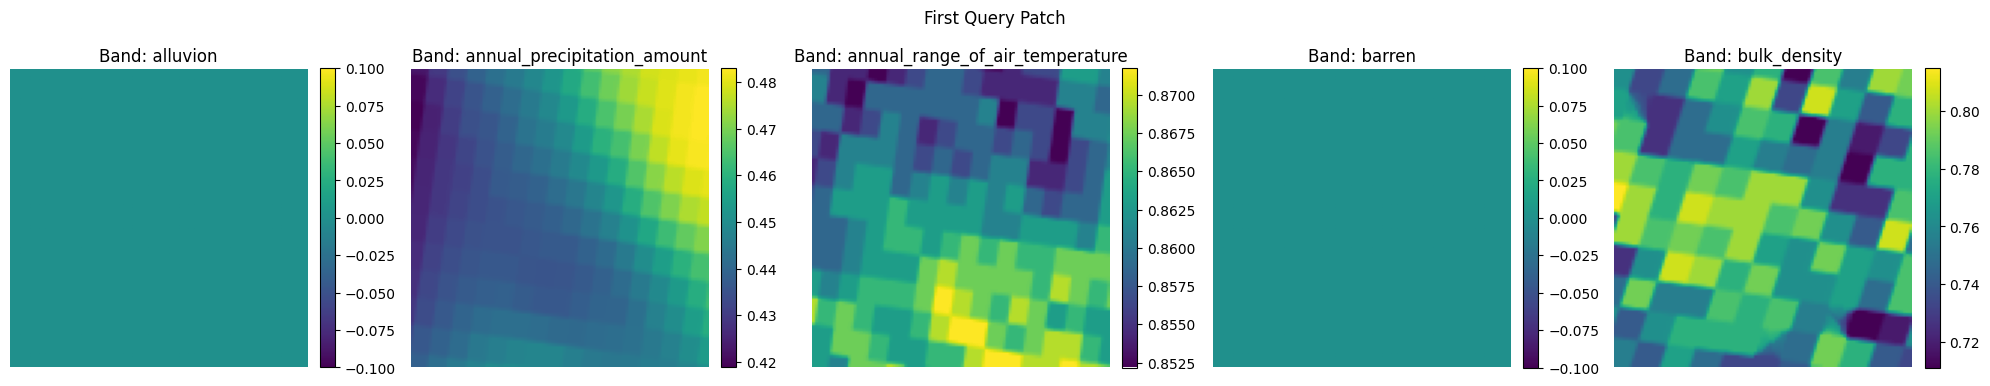

In [34]:
fig = pred_100_dataset.plot(
    sample=pred_100_dataset[queries[3]],
    bands=list(pred100_raster_names[:5]),  # plot first 5 bands as example
    show_titles=True,
    suptitle="First Query Patch"
)
plt.show()

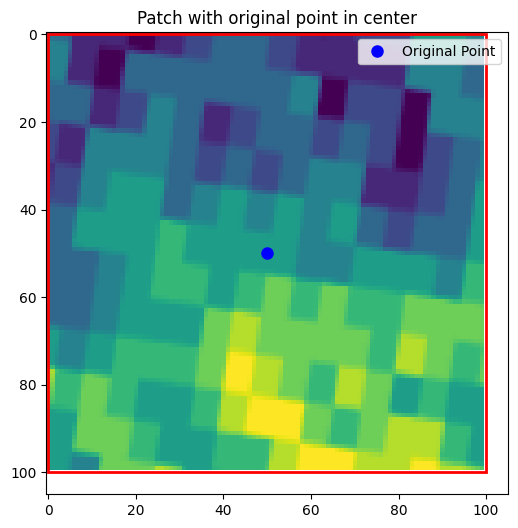

In [491]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Take the first patch
point_index = 3
query = queries[point_index]
patch_data = pred_100_dataset[query]['image']  # shape: [C, H, W]

# Pick a band to visualize (e.g., first band)
band_data = patch_data[2].numpy()  

# Plot the raster patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(band_data, cmap='viridis', origin='upper')

# Get patch bounds in raster CRS
xmin, xmax = query.minx, query.maxx
ymin, ymax = query.miny, query.maxy

# Draw rectangle around patch (in pixel coordinates)
rect = patches.Rectangle(
    (0, 0),  # top-left in array coordinates
    band_data.shape[1],  # width in pixels
    band_data.shape[0],  # height in pixels
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

# Plot original point in pixel coordinates relative to patch
# Convert map coordinates to pixels
point = sampler.points_in_dataset_crs.geometry.iloc[point_index]
# You need to know the pixel resolution (meters per pixel) for correct conversion.
# If patch_data.shape matches the patch size in meters, then:
pixel_size_x = (xmax - xmin) / band_data.shape[1]
pixel_size_y = (ymax - ymin) / band_data.shape[0]
x_center = (point.x - xmin) / pixel_size_x
y_center = (ymax - point.y) / pixel_size_y
ax.plot(x_center, y_center, 'bo', markersize=8, label='Original Point')

ax.set_title("Patch with original point in center")
ax.legend()
plt.show()


In [498]:
queries[0]

BoundingBox(minx=-746157.2280517358, maxx=-736157.2280517358, miny=317206.01150085626, maxy=327206.01150085626, mint=0.0, maxt=9.223372036854776e+18)

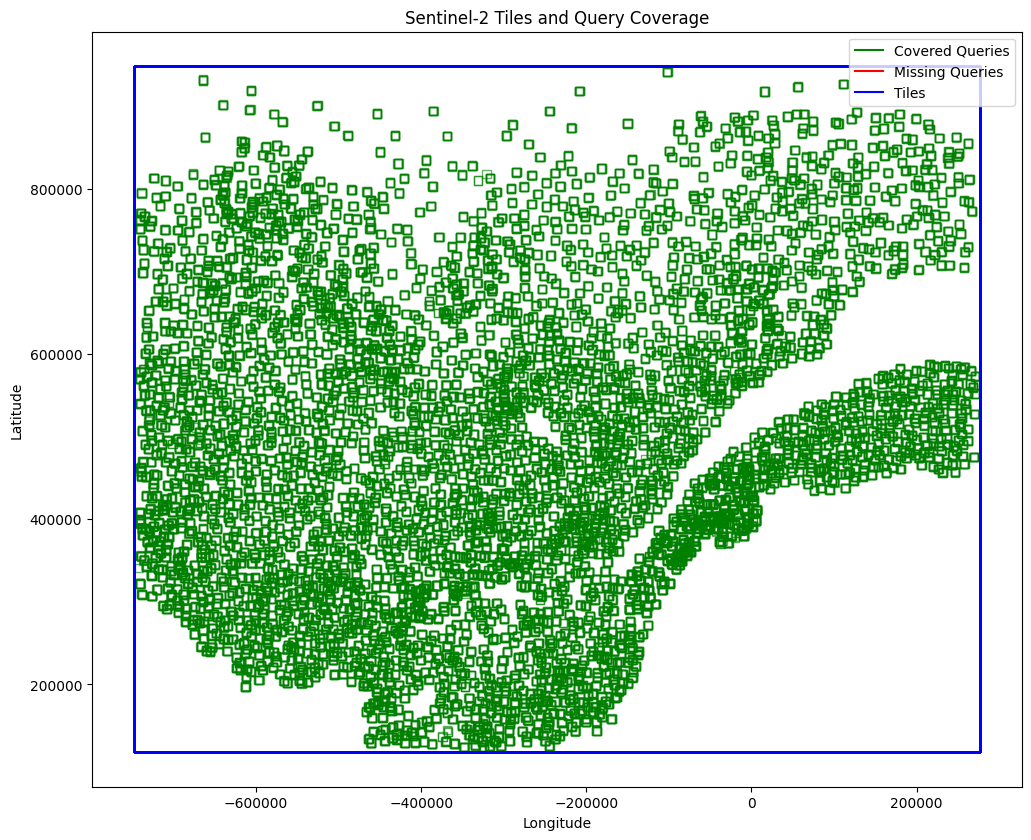

In [69]:
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchgeo.datasets import Sentinel2
from pyproj import Transformer

dataset = pred_100_dataset
processed_species_original_locations.to_crs(dataset.crs, inplace=True)  # Ensure locations are in dataset CRS   
point_sampler = PointGeoSampler(
    dataset=dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
dataset_queries = point_sampler.get_all_queries()


# Convert raster bounds to GeoDataFrame in their CRS, and reproject to common CRS before concatenation
tile_gdfs = []
for fpath in dataset.files:
    with rasterio.open(fpath) as src:
        tile_box = box(*src.bounds)
        gdf_tile = gpd.GeoDataFrame(geometry=[tile_box], crs=src.crs)
        gdf_tile = gdf_tile.to_crs(dataset.crs)  # Reproject to dataset CRS
        tile_gdfs.append(gdf_tile)

# Concatenate all tiles (now all in dataset CRS)
tiles_gdf = gpd.GeoDataFrame(pd.concat(tile_gdfs, ignore_index=True), crs=dataset.crs)

# Function to plot queries and tiles
def plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    def add_bboxes(queries, color, label, fill=False):
        for q in queries:
            width = q.maxx - q.minx
            height = q.maxy - q.miny
            ax.add_patch(Rectangle(
                (q.minx, q.miny), width, height,
                fill=fill, edgecolor=color, linewidth=1, alpha=0.6
            ))
        ax.plot([], [], color=color, label=label)
    
    add_bboxes(covered_queries, "green", "Covered Queries")
    add_bboxes(missing_queries, "red", "Missing Queries")
    
    #Plot tile bounding boxes
    for geom in tiles_gdf.geometry:
        minx, miny, maxx, maxy = geom.bounds
        ax.add_patch(Rectangle(
            (minx, miny), maxx - minx, maxy - miny,
            fill=False, edgecolor="blue", linewidth=1, alpha=0.5
        ))
    ax.plot([], [], color="blue", label="Tiles")
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Sentinel-2 Tiles and Query Coverage")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Example usage
covered_queries = [q for q in dataset_queries if q not in missing_queries]
plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf)


In [9]:
import zarr
import geopandas as gpd
from rasterio.windows import from_bounds
from torchgeo.datasets import RasterDataset
import numpy as np
import time
import numcodecs
import rasterio
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import psutil
import os

def extract_patches_sequentially(
    dataset: RasterDataset,
    locations: gpd.GeoSeries,
    zarr_path: str,
    side_length_meters: float,
    memory_threshold_mb: float = 4096,
    group_name: str = 'pred_100',
    channel_min: list = None,    # Per-band minimum values
    channel_max: list = None,    # Per-band maximum values
    n_workers: int = None,       # Number of worker processes (None = auto)
):
    """
    Extract patches from a RasterDataset, optionally normalize them, and store in a Zarr archive.
    Handles both separate files per band and multiple bands in the same file(s).

    Parameters
    ----------
    dataset : RasterDataset
        TorchGeo dataset containing raster files.
    locations : gpd.GeoSeries
        GeoSeries of point geometries where patches should be extracted.
    zarr_path : str
        Path to the Zarr archive to write to.
    side_length_meters : float
        Side length of each patch in meters.
    memory_threshold_mb : float, optional
        Maximum memory to use across ALL processes before flushing patches to disk.
    group_name : str, optional
        Name of the group in `raster_data/` where patches will be stored.
    channel_min, channel_max : list, optional
        Per-band min/max values for normalization. Must be the same length as number of bands.
    n_workers : int, optional
        Number of worker processes. If None, uses CPU count - 1.
    """
    
    # Open Zarr in append mode to keep existing data
    root = zarr.open(zarr_path, mode='a', zarr_version=2)
    raster_root_group = root.require_group('raster_data')
    current_data_group = raster_root_group.require_group(group_name)
    compressor = numcodecs.Blosc(cname='lz4', clevel=5, shuffle=numcodecs.Blosc.SHUFFLE)
    
    # Create sampler
    point_geo_sampler = PointGeoSampler(
        dataset=dataset,
        locations=locations,
        side_length_meters=side_length_meters,
    )
    queries = point_geo_sampler.get_all_queries()
    print(f"First query: {queries[0]}")
    
    # Generate patch IDs
    patch_ids = [
        f"{pt.x:.4f}_{pt.y:.4f}".replace('.', '_')
        for pt in locations.geometry
    ]

    # Determine data structure and get dimensions
    first_sample = dataset[queries[0]]
    first_patch = first_sample['image'].numpy()
    n_bands, patch_height, patch_width = first_patch.shape
    patch_dtype = np.float32
    
    print(f"Dataset info:")
    print(f"  - separate_files: {dataset.separate_files}")
    print(f"  - n_bands: {n_bands}")
    print(f"  - n_files: {len(dataset.files)}")
    print(f"  - patch_shape: ({n_bands}, {patch_height}, {patch_width})")

    # Pre-allocate Zarr arrays
    print("Pre-allocating Zarr arrays...")
    for patch_id in patch_ids:
        if patch_id not in current_data_group:
            current_data_group.create(
                name=patch_id,
                shape=(n_bands, patch_height, patch_width),
                dtype=patch_dtype,
                chunks=(1, patch_height, patch_width),
                compressor=compressor
            )
    
    # Process based on file structure
    if dataset.separate_files:
        # Original logic for separate files per band
        _process_separate_files(
            dataset, queries, patch_ids, current_data_group,
            memory_threshold_mb, channel_min, channel_max
        )
    else:
        _process_combined_files_seq(
            dataset, queries, patch_ids, current_data_group,
            memory_threshold_mb, channel_min, channel_max
        )

    print(f"Patches saved at {zarr_path}")

def _process_separate_files(dataset, queries, patch_ids, current_data_group,
                           memory_threshold_mb, channel_min, channel_max):
    """Process datasets where each band is in a separate file"""
    print("Processing separate files per band...")
    
    in_memory_patches_by_file = []
    current_memory_usage_mb = 0
    start_time = time.time()
    
    for file_index, filepath in enumerate(dataset.files):
        with rasterio.open(filepath) as src:
            print(f"Processing band {file_index + 1}/{len(dataset.files)}: {filepath}")

            patches_for_this_band = []
            for loc_index, query_bbox in enumerate(queries):
                try:
                    window = from_bounds(
                        query_bbox.minx, query_bbox.miny,
                        query_bbox.maxx, query_bbox.maxy,
                        src.transform
                    )
                    patch = src.read(window=window).squeeze().astype(np.float32)
                    
                    # Normalization (only if channel_min and channel_max are provided)
                    if channel_min is not None and channel_max is not None:
                        min_val = channel_min[file_index]
                        max_val = channel_max[file_index]
                        
                        if max_val > min_val:
                            patch = (patch - min_val) / (max_val - min_val)
                            patch = np.clip(patch, 0, 1)

                    patches_for_this_band.append(patch)
                    current_memory_usage_mb += (patch.size * patch.itemsize) / (1024**2)
                except rasterio.errors.RasterioIOError:
                    patches_for_this_band.append(None)
            
            in_memory_patches_by_file.append(patches_for_this_band)

            # Save when memory limit reached or last file processed
            if current_memory_usage_mb >= memory_threshold_mb or file_index == len(dataset.files) - 1:
                print("Saving batch...")
                save_start_time = time.time()
                for batch_file_index, patches_list in enumerate(in_memory_patches_by_file):
                    original_file_index = file_index - len(in_memory_patches_by_file) + 1 + batch_file_index
                    for loc_index, patch in enumerate(patches_list):
                        if patch is not None:
                            patch_id = patch_ids[loc_index]
                            current_data_group[patch_id][original_file_index, :, :] = patch
                print(f"Batch saved in {time.time() - save_start_time:.2f}s")
                
                in_memory_patches_by_file = []
                current_memory_usage_mb = 0

    print(f"Extraction complete in {time.time() - start_time:.2f}s")

    print(f"Extraction complete in {time.time() - start_time:.2f}s")

from multiprocessing import Process, Queue
import time

def _zarr_saver(save_queue, current_data_group):
    """
    Background process that receives batches of patches and saves them to Zarr.
    """
    while True:
        item = save_queue.get()
        if item is None:  # Poison pill = stop
            break
        batch_patches = item
        save_start = time.time()
        for patch_id, patch in batch_patches.items():
            current_data_group[patch_id][:, :, :] = patch
        print(f"Saved {len(batch_patches)} patches in {time.time() - save_start:.2f}s")


def _process_combined_files_seq(dataset, queries, patch_ids, current_data_group,
                                      memory_threshold_mb, channel_min, channel_max):
    """Sequential extractor with async saving in a separate process"""
    print("Processing combined bands sequentially with async saving...")

    start_time = time.time()

    first_sample = dataset[queries[0]]
    n_bands, patch_height, patch_width = first_sample['image'].shape
    patch_dtype = np.float32

    in_memory_patches = {}
    current_memory_usage_mb = 0

    # Start background saver
    save_queue = Queue(maxsize=1)  # ensures we never buffer >1 batch
    saver = Process(target=_zarr_saver, args=(save_queue, current_data_group))
    saver.start()

    with tqdm(total=len(queries), desc="Processing patches (seq+async)") as pbar:
        for i, query_bbox in enumerate(queries):
            patch_id = patch_ids[i]
            try:
                sample = dataset[query_bbox]
                patch = sample['image'].numpy().astype(patch_dtype)

                # Normalization
                if channel_min is not None and channel_max is not None:
                    for b in range(patch.shape[0]):
                        min_val, max_val = channel_min[b], channel_max[b]
                        if max_val > min_val:
                            patch[b] = np.clip((patch[b] - min_val) / (max_val - min_val), 0, 1)

                # Collect patch in memory
                in_memory_patches[patch_id] = patch
                current_memory_usage_mb += patch.nbytes / (1024 ** 2)

                # If threshold exceeded, push batch to saver
                if current_memory_usage_mb >= memory_threshold_mb:
                    print(f"Queueing batch (~{current_memory_usage_mb:.2f} MB) for saving...")
                    save_queue.put(in_memory_patches)  # blocks if saver is still writing
                    in_memory_patches = {}
                    current_memory_usage_mb = 0

            except Exception as e:
                print(f"Error processing patch {patch_id}: {e}")

            pbar.update(1)

    # Final flush
    if in_memory_patches:
        print(f"Queueing final batch (~{current_memory_usage_mb:.2f} MB) for saving...")
        save_queue.put(in_memory_patches)

    # Stop saver
    save_queue.put(None)
    saver.join()

    print(f"Extraction complete in {time.time() - start_time:.2f}s")


In [503]:
locations

0    POINT (-741157.228 322206.012)
1    POINT (-740968.538 322143.985)
2    POINT (-740825.054 322103.996)
3    POINT (-740548.834 322019.529)
4    POINT (-740734.244 322076.046)
Name: geometry, dtype: geometry

In [563]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path
)

Pre-allocating Zarr arrays...
Processing file 1/67: ../data/data_layers/predictors_100_QC_normalized/alluvion.tif
Processing file 2/67: ../data/data_layers/predictors_100_QC_normalized/annual_precipitation_amount.tif
Processing file 3/67: ../data/data_layers/predictors_100_QC_normalized/annual_range_of_air_temperature.tif
Processing file 4/67: ../data/data_layers/predictors_100_QC_normalized/barren.tif
Processing file 5/67: ../data/data_layers/predictors_100_QC_normalized/bulk_density.tif
Memory threshold reached or last file processed. Saving batch...
Batch saved in 217.05s
Processing file 6/67: ../data/data_layers/predictors_100_QC_normalized/clay.tif
Processing file 7/67: ../data/data_layers/predictors_100_QC_normalized/combined_mask.tif
Processing file 8/67: ../data/data_layers/predictors_100_QC_normalized/coniferous.tif
Processing file 9/67: ../data/data_layers/predictors_100_QC_normalized/cropland.tif
Processing file 10/67: ../data/data_layers/predictors_100_QC_normalized/deciduo

In [ ]:
import zarr
import matplotlib.pyplot as plt

# Path to your Zarr group
zarr_path = "../data/zarr_patches/pred100.zarr"

# Open the zarr group
zarr_group = zarr.open_group(zarr_path, mode='r')['raster_data']['pred_100']

# List all stored patches keys (ids)
patch_ids = list(zarr_group.array_keys())
print("Available patch IDs:", patch_ids[:5])  # show first 5 keys

# Load the first patch (replace with the id you want)
first_patch_id = patch_ids[3]
patch = zarr_group[first_patch_id][...]

print("Patch shape:", patch.shape)  # should be (channels, H, W) or maybe (H, W, channels)

# # If last dim is channels instead of first dim, transpose:
# if patch.shape[-1] <= 10:  # heuristic: if last dim is small (bands)
#     patch = patch.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)

def visualize_bands(patch, num_bands=5):
    num_bands = min(num_bands, patch.shape[0])
    max_per_row = 5
    nrows = (num_bands + max_per_row - 1) // max_per_row
    ncols = min(num_bands, max_per_row)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = np.array(axs).reshape(-1)
    for i in range(num_bands):
        band = patch[i]
        axs[i].imshow(band, cmap='viridis')
        axs[i].set_title(f'Band {i+1}')
        axs[i].axis('off')
    # Hide unused axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()

visualize_bands(patch, num_bands=5)


Available patch IDs: ['-331648_6281_136309_3800', '-293174_0786_428530_5746', '-131052_2708_490049_3918', '-157842_9873_514743_1391', '-386587_7695_563208_5866']
Patch shape: (67, 100, 100)


-293174_0786_428530_5746


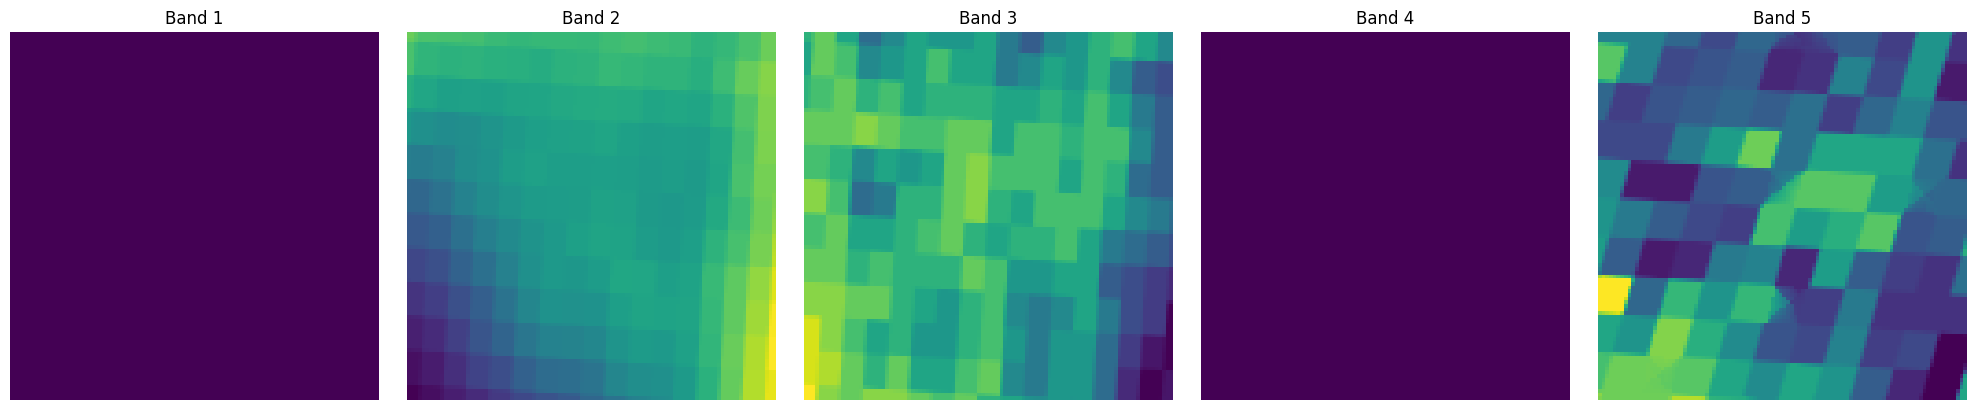

-331648_6281_136309_3800


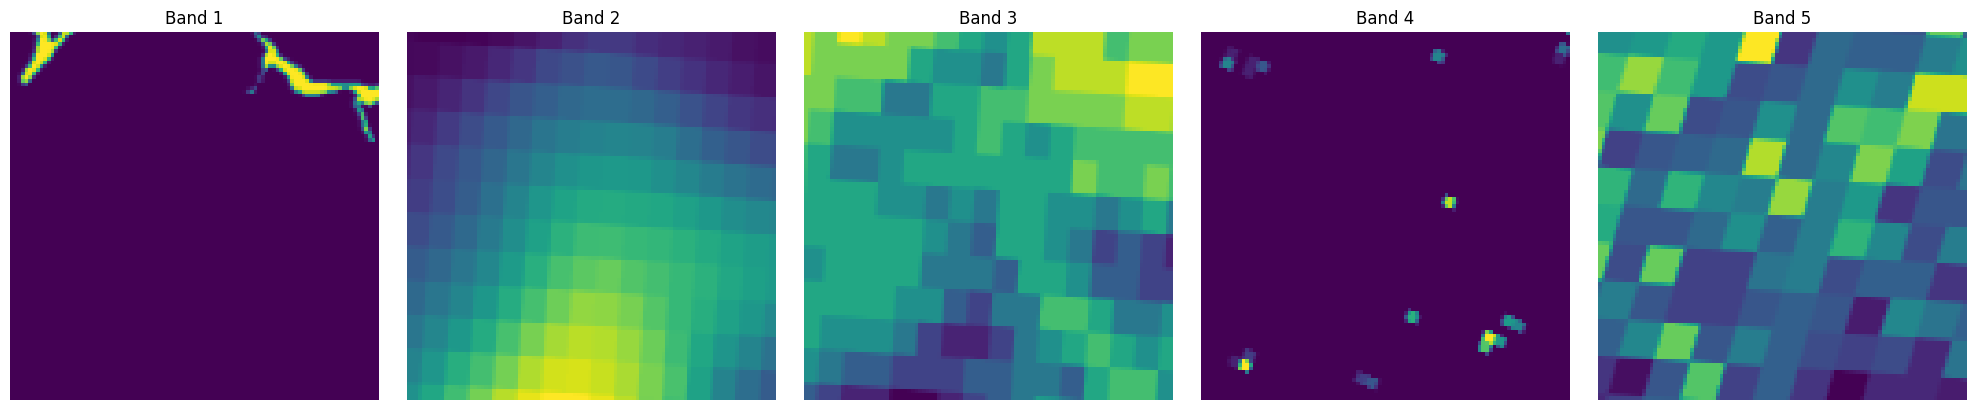

-131052_2708_490049_3918


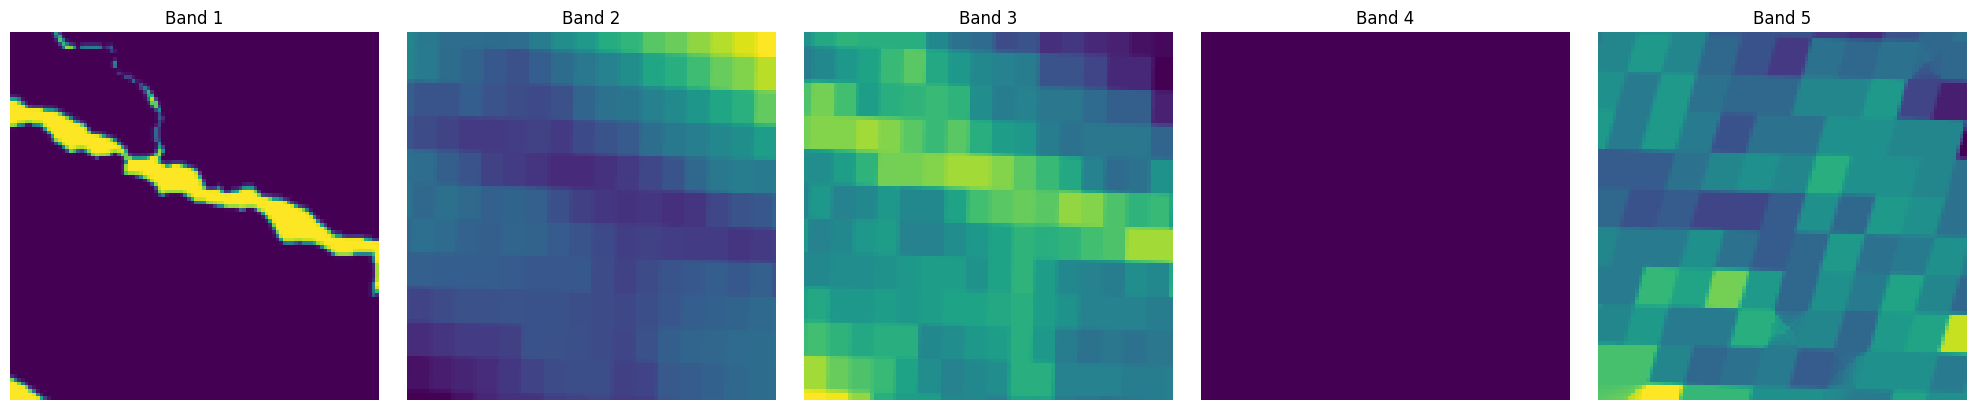

-386587_7695_563208_5866


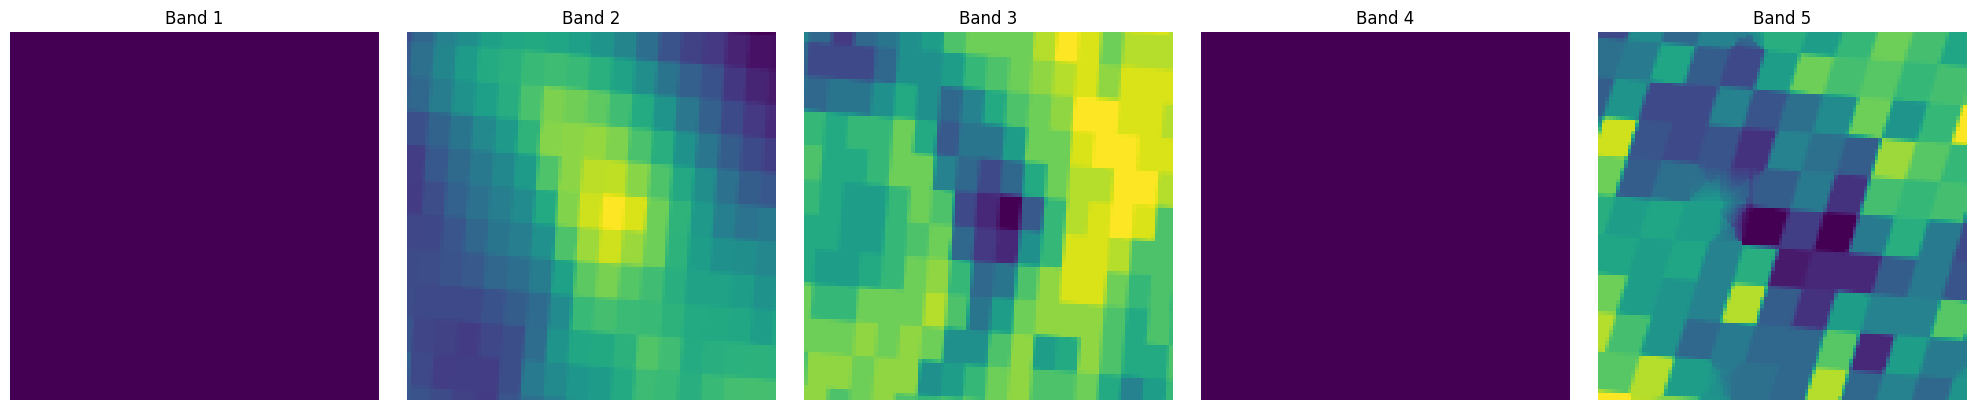

-542478_2951_350609_2562


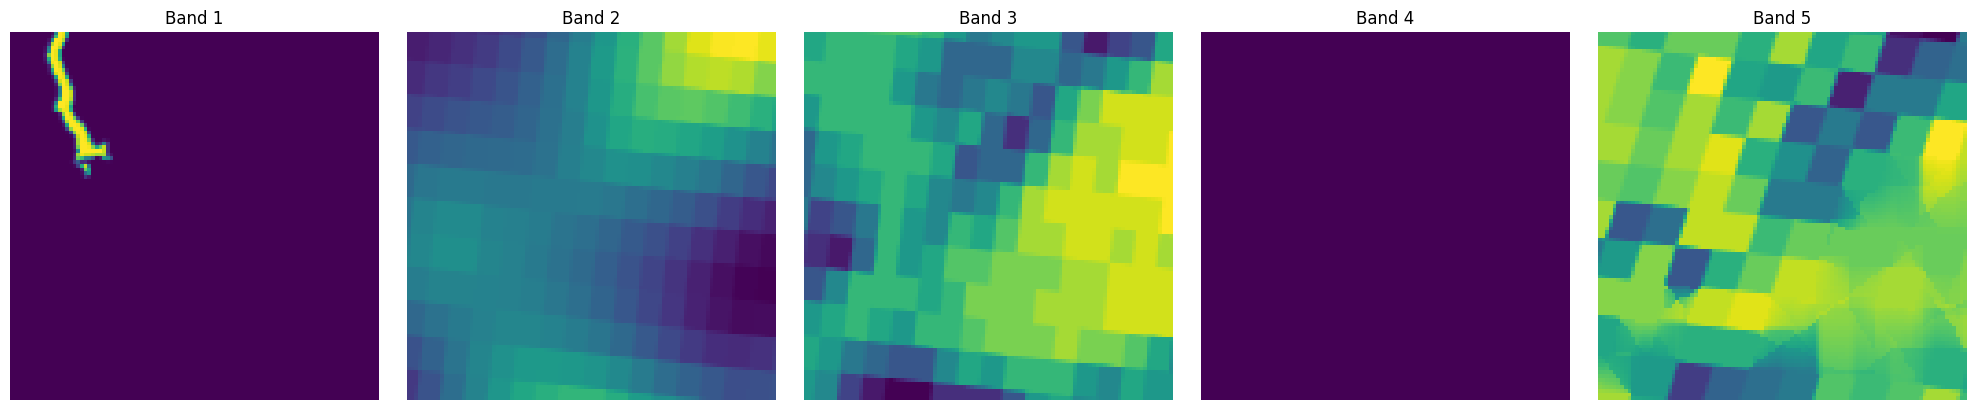

-157842_9873_514743_1391


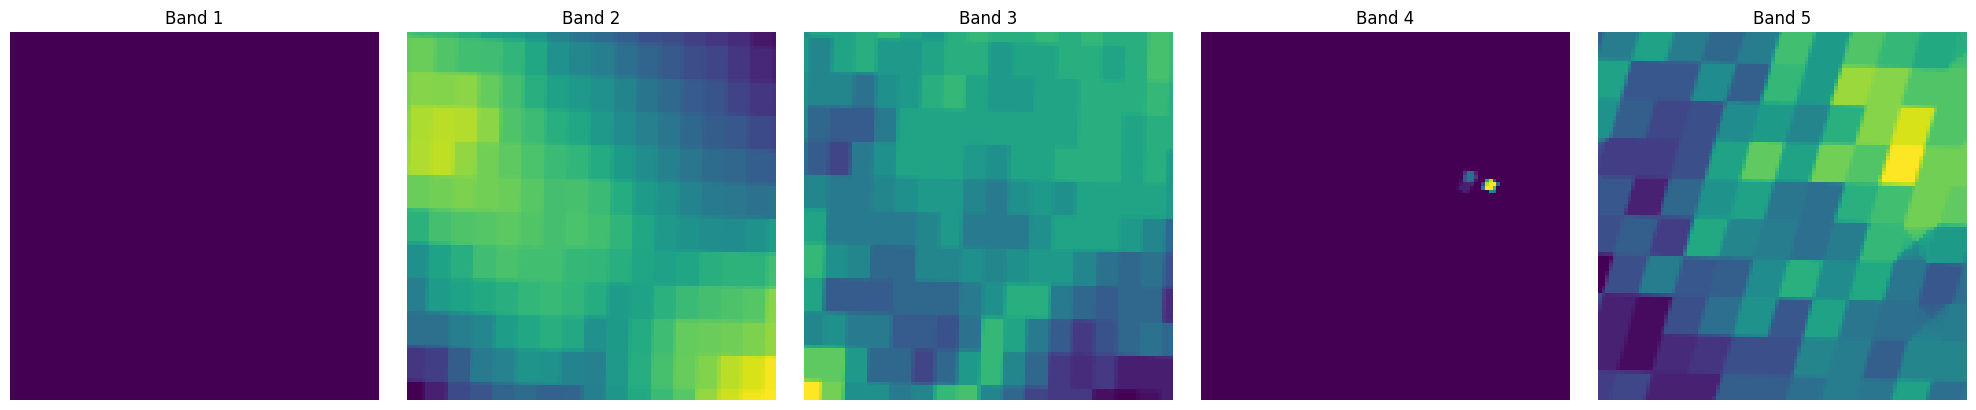

-127697_8246_695413_5510


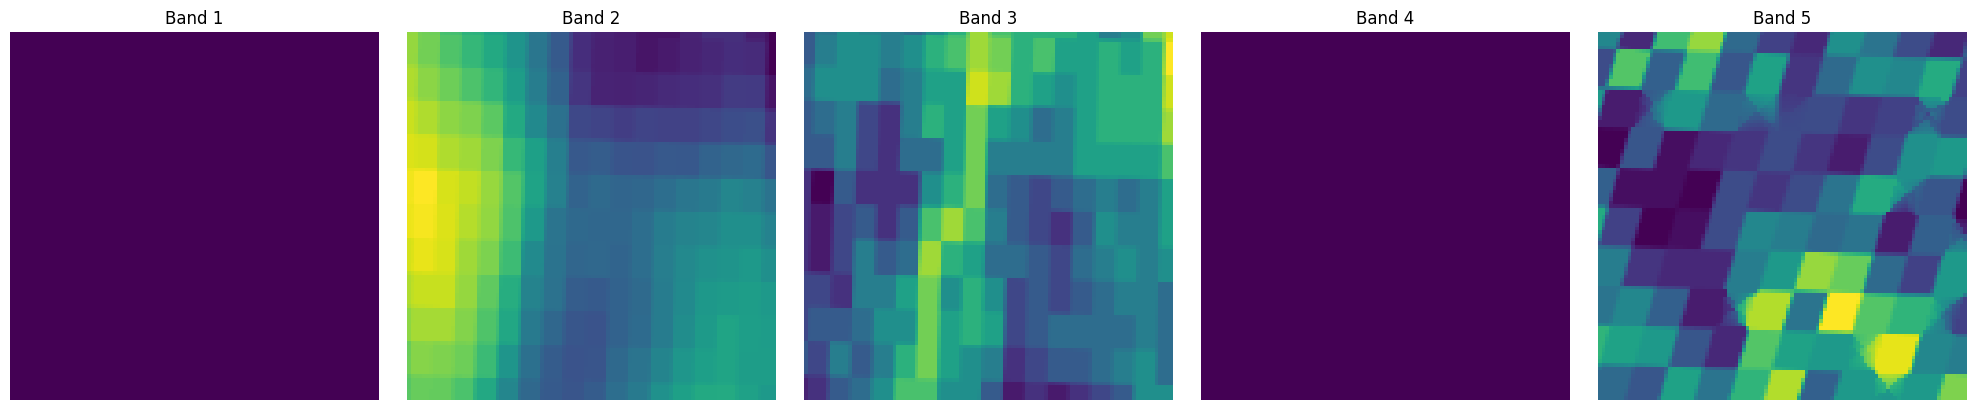

124493_9373_548993_8611


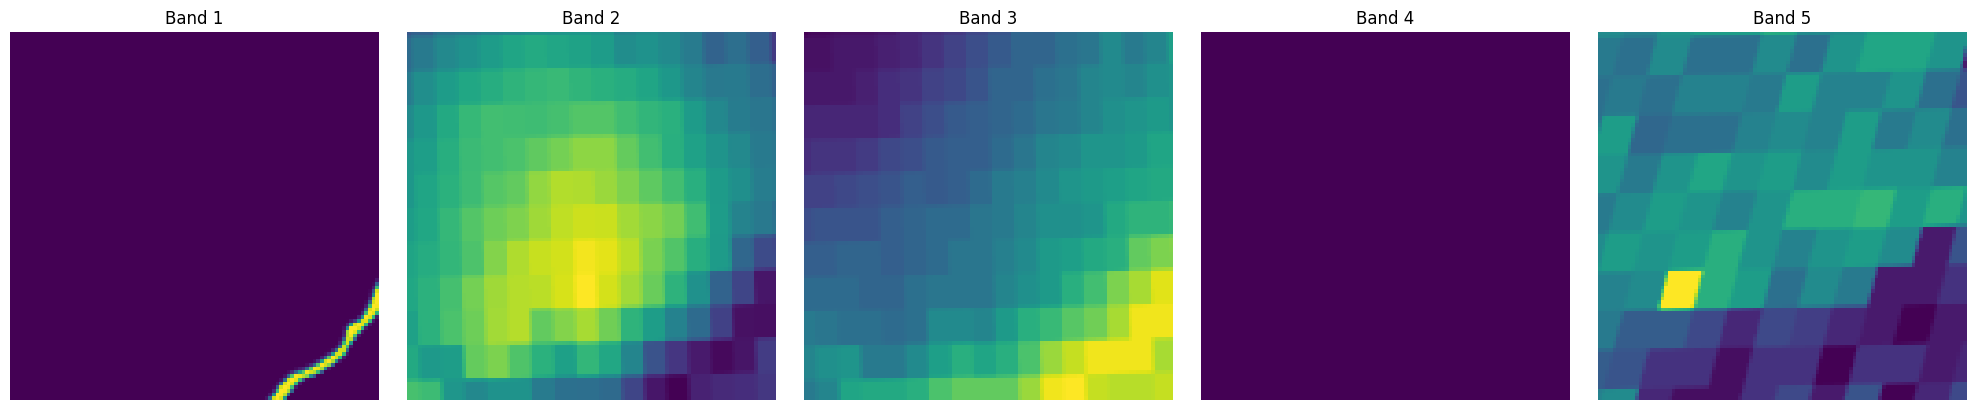

19268_2206_628381_1898


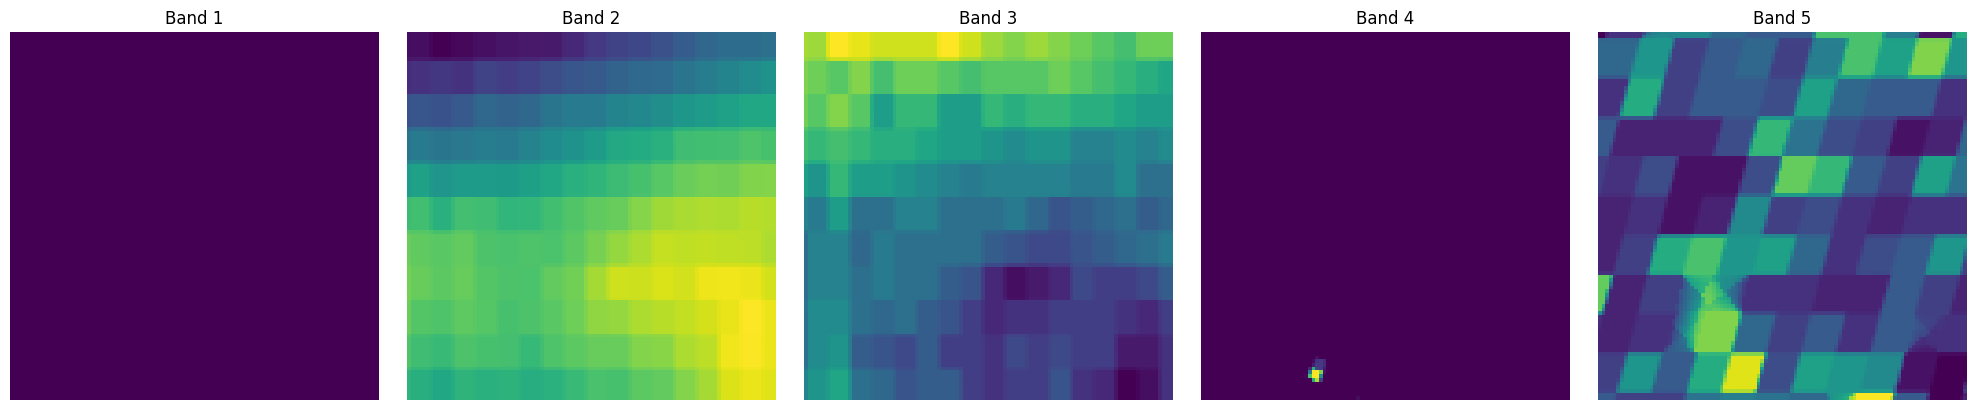

-359186_6970_128069_9272


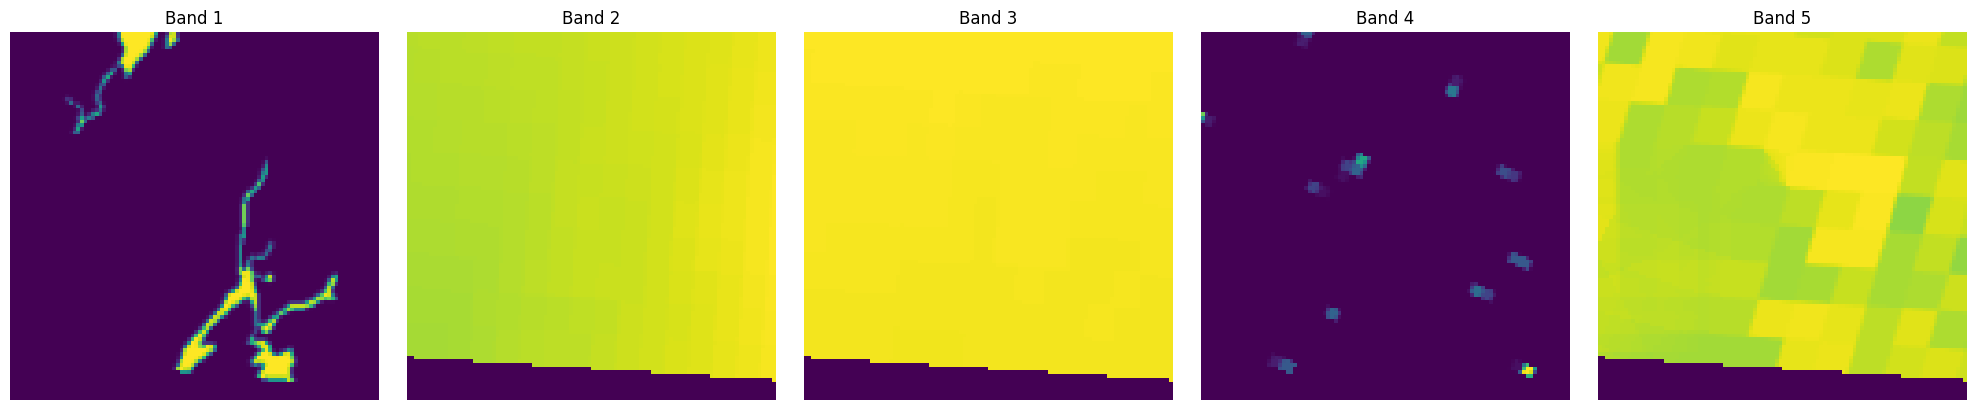

In [565]:
# Load the first patch (replace with the id you want)
for i in range(10):
    first_patch_id = patch_ids[i]
    patch = zarr_group[first_patch_id][...]
    print(patch_ids[i])
    visualize_bands(patch, num_bands=5)


In [91]:
import zarr

zarr_group = zarr.open_group("../data/data_layers/pred_100_dataset.zarr", mode='r')

print("Top-level keys:", list(zarr_group.group_keys()))  # ['raster_data']

raster_data_group = zarr_group["raster_data"]

print("Arrays inside 'raster_data':", list(raster_data_group.array_keys()))  # should list patch IDs


Top-level keys: ['raster_data']
Arrays inside 'raster_data': ['-578.0180_421.9820_-453.4386_546.5614', '-577.8425_422.1575_-453.1483_546.8517', '-578.1797_421.8203_-453.5450_546.4550', '-577.8442_422.1558_-453.1521_546.8479', '-577.9276_422.0724_-453.1859_546.8141', '-578.1722_421.8278_-453.5457_546.4543', '-578.0310_421.9690_-453.3110_546.6890', '-578.1020_421.8980_-453.1426_546.8574', '-578.0341_421.9659_-453.3117_546.6883', '-578.2291_421.7709_-453.3784_546.6216', '-578.2271_421.7729_-453.2434_546.7566', '-578.2727_421.7273_-453.4601_546.5399', '-577.8435_422.1565_-453.1504_546.8496', '-578.2657_421.7343_-453.4625_546.5375', '-578.2224_421.7776_-453.2487_546.7513', '-578.2261_421.7739_-453.3754_546.6246', '-578.1124_421.8876_-453.3461_546.6539', '-578.0360_421.9640_-453.3121_546.6879', '-578.2704_421.7296_-453.4608_546.5392', '-578.2256_421.7744_-453.2451_546.7549', '-577.9916_422.0084_-453.2377_546.7623', '-578.1131_421.8869_-453.3474_546.6526', '-578.1149_421.8851_-453.3508_546.64

### Satelitte data

In [ ]:
# Now use TorchGeo's built-in Sentinel2 dataset
import torch
from torchgeo.datasets import Sentinel2
from pathlib import Path
from torch.utils.data import DataLoader
from torchgeo.samplers import RandomGeoSampler

locations = processed_species_original_locations.geometry
locations = locations.to_crs("EPSG:4326")  # Ensure locations are in WGS84 for sampling
data_dir_sentinel2 = Path("../data/sentinel2_tiles")
sentinel2_dataset = Sentinel2(paths=str(data_dir_sentinel2), bands=['B02'], res=100, transforms=None)

sentinel2_point_sampler = PointGeoSampler(
    dataset=sentinel2_dataset,
    locations=locations,
    side_length_meters=10000,
)
sentinel2_queries = sentinel2_point_sampler.get_all_queries()
print(sentinel2_queries[0])

BoundingBox(minx=-83.184149, maxx=-73.184149, miny=41.45549900000005, maxy=51.45549900000005, mint=1717214400.0, maxt=1720152000.999999)


In [50]:
locations

0         POINT (-78.18415 46.4555)
1         POINT (-78.1816 46.45517)
2        POINT (-78.17968 46.45499)
3        POINT (-78.17597 46.45457)
4        POINT (-78.17846 46.45485)
                    ...            
24727    POINT (-70.66489 45.40489)
24728    POINT (-70.66828 45.40126)
24729    POINT (-70.66694 45.40269)
24730    POINT (-70.66591 45.40381)
24731    POINT (-70.66132 45.40872)
Name: geometry, Length: 24732, dtype: geometry

Patch shape: torch.Size([5, 500, 500])


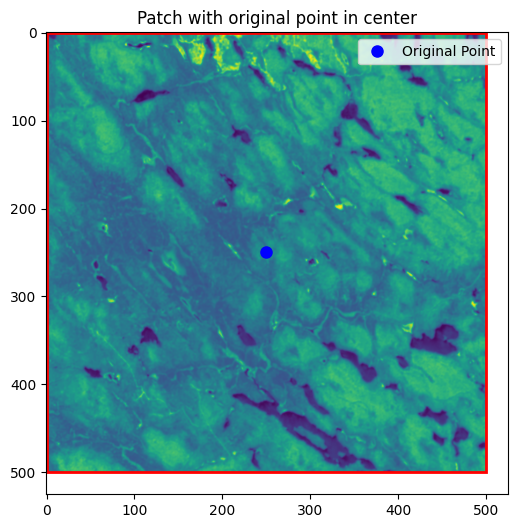

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Take the first patch
point_index = 3
query = sentinel2_queries[point_index]
patch_data = sentinel2_dataset[query]['image']  # shape: [C, H, W]

# Pick a band to visualize (e.g., first band)
band_data = patch_data[4].numpy()  

# Plot the raster patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(band_data, cmap='viridis', origin='upper')

# Get patch bounds in raster CRS
xmin, xmax = query.minx, query.maxx
ymin, ymax = query.miny, query.maxy

# Draw rectangle around patch (in pixel coordinates)
rect = patches.Rectangle(
    (0, 0),  # top-left in array coordinates
    band_data.shape[1],  # width in pixels
    band_data.shape[0],  # height in pixels
    linewidth=2, edgecolor='red', facecolor='none'
)
ax.add_patch(rect)

# Plot original point in pixel coordinates relative to patch
# Convert map coordinates to pixels
point = sentinel2_point_sampler.points_in_dataset_crs.geometry.iloc[point_index]
# You need to know the pixel resolution (meters per pixel) for correct conversion.
# If patch_data.shape matches the patch size in meters, then:
pixel_size_x = (xmax - xmin) / band_data.shape[1]
pixel_size_y = (ymax - ymin) / band_data.shape[0]
x_center = (point.x - xmin) / pixel_size_x
y_center = (ymax - point.y) / pixel_size_y
ax.plot(x_center, y_center, 'bo', markersize=8, label='Original Point')

ax.set_title("Patch with original point in center")
ax.legend()
print(f"Patch shape: {patch_data.shape}")  # should be (C, H, W)
plt.show()


In [ ]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=pred_100_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path
)

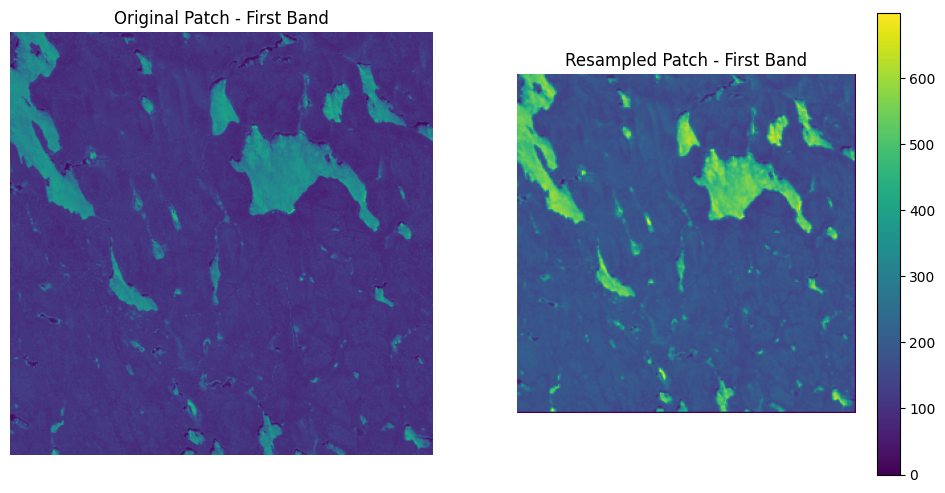

In [621]:
#plot the resampled patch first band next to the original patch first band
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(patch['image'][0], cmap='viridis')
ax[0].set_title("Original Patch - First Band")
ax[0].axis('off')

ax[1].imshow(resampled_patch[0], cmap='viridis')
ax[1].set_title("Resampled Patch - First Band")
ax[1].axis('off')

plt.colorbar(ax[1].images[0], ax=ax[1])
plt.show()

### Download Sentinel-2 data for specific tiles and bands

In [10]:
processed_species_original_locations.to_crs('EPSG:4326', inplace=True)

In [ ]:
import ee
import os
import re
import geemap
import time
import rasterio
import numpy as np
from tqdm import tqdm

ee.Initialize()

# --- User parameters ---
OUTPUT_DIR = "../data/sentinel2_tiles_drive"
os.makedirs(OUTPUT_DIR, exist_ok=True)

START_DATE = "2024-06-01"
END_DATE = "2024-08-28"
CLOUD_COVER = 30

BANDS = ['B2','B3','B4','B8','B11']
DERIVED_BANDS = ['NDVI', 'moisture']
ALL_BANDS = BANDS + DERIVED_BANDS

TILE_SIZE = 1.0  # ~100km tiles

PATTERN = re.compile(
    r"""
    ^T(?P<tile>\d{2}[A-Z]{3})                # Tile, e.g., T17TPL
    _
    (?P<date>\d{8})                           # Date, YYYYMMDD
    (?:T(?P<time>\d{6}))?                     # Optional time, HHMMSS
    _
    (?P<band>(?:B(?:\d{1,2}|8A)|NDVI|moisture)) # Band
    (?:_(?P<res>\d{1,3}m))?                   # Optional resolution
    \.(?P<ext>[^.]+)$                         # File extension
    """,
    re.VERBOSE | re.IGNORECASE,
)

# --- Derived bands ---
def add_derived_bands(composite):
    ndvi = composite.expression('(NIR - RED) / (NIR + RED)',
        {'NIR': composite.select('B8'), 'RED': composite.select('B4')}).rename('NDVI')
    moisture = composite.expression('(SWIR - NIR) / (SWIR + NIR)',
        {'SWIR': composite.select('B11'), 'NIR': composite.select('B8')}).rename('moisture')
    return composite.addBands(ndvi).addBands(moisture)

# --- Validate a tile ---
def is_tile_valid(filepath, nodata=None, min_valid_pixels=10):
    try:
        with rasterio.open(filepath) as src:
            data = src.read(1, masked=True)
            if nodata is not None:
                data = np.ma.masked_equal(data, nodata)
            valid_pixels = np.count_nonzero(~data.mask)
            return valid_pixels >= min_valid_pixels
    except Exception as e:
        print(f"Tile read failed for {filepath}: {e}")
        return False

# --- Export large tile to Drive / local folder ---
def export_tile(tile_geom):
    collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(tile_geom)
                  .filterDate(START_DATE, END_DATE)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_COVER))
                  .median()
                  .select(BANDS))
    
    collection = add_derived_bands(collection)
    
    first_img = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterBounds(tile_geom)\
                    .filterDate(START_DATE, END_DATE)\
                    .sort('system:time_start')\
                    .first()
    timestamp = ee.Date(first_img.get('system:time_start')).format('yyyyMMdd').getInfo()
    mgrs_id = first_img.get('MGRS_TILE').getInfo()
    
    for band in ALL_BANDS:
        if band in ['B8', 'B11']:
            continue
        band_image = collection.select(band)
        filename = f"T{mgrs_id}_{timestamp}_{band}.tif"
        filepath = os.path.join(OUTPUT_DIR, filename)
        
        try:
            geemap.ee_export_image(
                ee_object=band_image,
                filename=filepath,
                scale=20,
                region=tile_geom,
                file_per_band=True
            )
            time.sleep(0.5)

            if not is_tile_valid(filepath):
                print(f"Warning: tile {filename} is invalid or empty, retrying download.")
                os.remove(filepath)
                # Retry once
                geemap.ee_export_image(
                    ee_object=band_image,
                    filename=filepath,
                    scale=20,
                    region=tile_geom,
                    file_per_band=True
                )
                time.sleep(0.5)
                if not is_tile_valid(filepath):
                    print(f"Failed again: {filename}")
                    os.remove(filepath)

        except Exception as e:
            print(f"Failed to export {filename}: {e}")
            if os.path.exists(filepath):
                os.remove(filepath)

# --- Create large tiles over AOI ---
def create_tiles(bbox, tile_size):
    minx, miny, maxx, maxy = bbox
    x_coords = [minx, maxx - tile_size]
    y_coords = [miny, maxy - tile_size]
    tiles = [(x, y, x + tile_size, y + tile_size) for x in x_coords for y in y_coords]
    return tiles

# --- Main ---
if __name__ == "__main__":
    bbox = processed_species_original_locations.total_bounds
    tiles = create_tiles(bbox, TILE_SIZE)
    
    for tile in tqdm(tiles):
        geom = ee.Geometry.Rectangle(tile)
        try:
            export_tile(geom)
        except Exception as e:
            print(f"Failed tile {tile}: {e}")


Downloaded T17UPT_20240602T000000_B2.tif
Downloaded T18TVR_20240601T000000_B2.tif
Downloaded T17UPT_20240602T000000_B3.tif
Downloaded T18TVS_20240701T000000_B2.tif
Downloaded T17TQN_20240619T000000_B2.tif
Downloaded T17UPT_20240602T000000_B2.tif
Downloaded T17UPQ_20240612T000000_B2.tif
Downloaded T18UVU_20240616T000000_B2.tif
Downloaded T18TUS_20240624T000000_B2.tif
Downloaded T17TQL_20240624T000000_B2.tif
Downloaded T18UVB_20240611T000000_B2.tif
Downloaded T18UUA_20240622T000000_B2.tif
Downloaded T18TUR_20240624T000000_B2.tif
Downloaded T17UPT_20240602T000000_B4.tif
Downloaded T18TVS_20240701T000000_B3.tif


Process ForkPoolWorker-197:
Process ForkPoolWorker-199:
Process ForkPoolWorker-203:
Process ForkPoolWorker-204:
Process ForkPoolWorker-201:
Process ForkPoolWorker-202:


KeyboardInterrupt: 

In [ ]:
geemap.ee_export_image

In [10]:
import os
import re
from pathlib import Path

# Updated pattern: allow NDVI and moisture as bands
PATTERN = re.compile(
    r"""
    ^T(?P<tile>\d{2}[A-Z]{3})                # Tile, e.g., T17TPL
    _
    (?P<date>\d{8})                           # Date, YYYYMMDD
    (?:T(?P<time>\d{6}))?                     # Optional time, HHMMSS
    _
    (?P<band>(?:B(?:\d{1,2}|8A)|NDVI|moisture)) # Band: B2, B02, B8A, NDVI, moisture
    (?:_(?P<res>\d{1,3}m))?                   # Optional resolution, e.g., 10m
    (?:\.(?P=band))?                          # Optional stray .{band}
    \.(?P<ext>[^.]+)$                         # File extension
    """,
    re.VERBOSE | re.IGNORECASE,
)

def normalize_band(band: str) -> str:
    """Normalize numeric bands to B02/B03 but keep NDVI and moisture as-is."""
    band_upper = band.upper()
    if band_upper in {"NDVI", "MOISTURE"}:
        return band_upper
    if band_upper.startswith("B"):
        tail = band_upper[1:]
        if tail.isdigit():
            return f"B{int(tail):02d}"
        return f"B{tail}"
    return band_upper

def build_target_name(tile, date, time, band, res, ext) -> str:
    """Build a corrected filename."""
    time = time if time else "000000"
    band = normalize_band(band)
    core = f"T{tile}_{date}T{time}_{band}"
    if res:
        core += f"_{res}"
    return f"{core}.{ext}"

def plan_rename(name: str):
    """Return the corrected filename if renaming is needed, else None."""
    m = PATTERN.match(name)
    if not m:
        return None
    tile = m.group("tile")
    date = m.group("date")
    time = m.group("time")
    band = m.group("band")
    res = m.group("res")
    ext = m.group("ext")
    target = build_target_name(tile, date, time, band, res, ext)
    return target if target != name else None

def fix_s2_filenames(base_path, recursive=True, commit=True, verbose=True):
    """
    Fix Sentinel-2/NDVI/moisture filenames and delete .zip files.

    Args:
        base_path (str or Path): directory or file to process.
        recursive (bool): scan subdirectories if True.
        commit (bool): apply changes if True, else dry-run.
        verbose (bool): print actions.
    """
    base_path = Path(base_path)
    renamed = deleted = examined = 0

    if base_path.is_file():
        paths = [base_path]
    else:
        paths = base_path.rglob("*") if recursive else base_path.iterdir()

    for path in paths:
        if not path.is_file():
            continue
        examined += 1
        name = path.name

        # Delete .zip files
        if name.lower().endswith(".zip"):
            if verbose:
                print(f"DELETE: {name}")
            if commit:
                path.unlink()
            deleted += 1
            continue

        # Plan rename
        new_name = plan_rename(name)
        if new_name:
            if verbose:
                print(f"RENAME: {name} -> {new_name}")
            if commit:
                target = path.with_name(new_name)
                if target.exists():
                    if verbose:
                        print(f"  !! Skipped, target exists: {target}")
                else:
                    path.rename(target)
            renamed += 1
        else:
            if verbose:
                if PATTERN.match(name):
                    print(f"OK   : {name}")
                else:
                    print(f"SKIP : {name} (not a recognized file)")

    if verbose:
        print(f"Examined: {examined} | Renamed: {renamed} | Deleted .zip: {deleted}")


# Example:
# fix_s2_filenames("/path/to/files", recursive=True, commit=True)


In [12]:
# Dry run (preview changes)
fix_s2_filenames("../data/sentinel2_tiles", recursive=False, commit=True)

RENAME: T18TVT_20240701_NDVI.NDVI.tif -> T18TVT_20240701T000000_NDVI.tif
RENAME: T17UPP_20240612_moisture.moisture.tif -> T17UPP_20240612T000000_MOISTURE.tif
OK   : T18UUB_20240611T000000_B04.tif
OK   : T17UQP_20240619T000000_B04.tif
RENAME: T17UPQ_20240612_NDVI.NDVI.tif -> T17UPQ_20240612T000000_NDVI.tif
RENAME: T19TFM_20240604_moisture.moisture.tif -> T19TFM_20240604T000000_MOISTURE.tif
RENAME: T18UUA_20240611_moisture.moisture.tif -> T18UUA_20240611T000000_MOISTURE.tif
RENAME: T19UDR_20240607_NDVI.NDVI.tif -> T19UDR_20240607T000000_NDVI.tif
RENAME: T18UXV_20240601_moisture.moisture.tif -> T18UXV_20240601T000000_MOISTURE.tif
OK   : T19UES_20240625T000000_B03.tif
OK   : T19UCP_20240625T000000_B04.tif
OK   : T19UDU_20240603T000000_B03.tif
RENAME: T19TCN_20240603_moisture.moisture.tif -> T19TCN_20240603T000000_MOISTURE.tif
OK   : T18UUB_20240611T000000_B02.tif
OK   : T17TPM_20240617T000000_B02.tif
OK   : T19UCQ_20240603T000000_B02.tif
RENAME: T18UXB_20240603_NDVI.NDVI.tif -> T18UXB_2024

### validating tiles coverage

In [73]:
import torch
from tqdm import tqdm
from torchgeo.datasets import Sentinel2
from torchgeo.datasets.utils import BoundingBox
from multiprocessing import Pool, cpu_count


def _check_query(args):
    """Worker function: returns (query, is_missing)."""
    dataset, query = args
    try:
        _ = dataset[query]
        return query, False
    except Exception:
        return query, True


def find_missing_queries_parallel(dataset: Sentinel2, all_queries: list, num_workers=None, chunksize=1):
    """
    Finds missing queries by attempting to load data in parallel.

    Args:
        dataset (Sentinel2): TorchGeo Sentinel2 dataset object.
        all_queries (list): List of BoundingBox objects.
        num_workers (int, optional): Number of worker processes (defaults to CPU cores).
        chunksize (int, optional): How many queries to send to each worker at a time.

    Returns:
        list: Missing BoundingBox queries.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)  # leave 1 core free

    missing_queries = []
    print(f"Checking each query in parallel with {num_workers} workers...")

    # Dataset object might not be pickleable; pass only minimal info if needed
    # If Sentinel2 uses lazy loading, separate dataset creation per process is safer
    with Pool(processes=num_workers) as pool:
        for query, is_missing in tqdm(
            pool.imap_unordered(_check_query, [(dataset, q) for q in all_queries], chunksize),
            total=len(all_queries),
        ):
            if is_missing:
                missing_queries.append(query)

    print(f"\nTotal queries: {len(all_queries)}")
    print(f"Queries covered: {len(all_queries) - len(missing_queries)}")
    print(f"Queries missing: {len(missing_queries)}")

    return missing_queries


# Example usage:
# Assuming `sentinel2_dataset` and `sentinel2_queries` are already defined
sentinel2_dataset = Sentinel2(paths=str("../data/sentinel2_tiles_normalized"), bands=['B02'], res=100, transforms=None)

sentinel2_point_sampler = PointGeoSampler(
    dataset=sentinel2_dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
sentinel2_queries = sentinel2_point_sampler.get_all_queries()
missing_queries = find_missing_queries_parallel(sentinel2_dataset, sentinel2_queries)

Checking each query in parallel with 11 workers...


100%|██████████| 24732/24732 [01:31<00:00, 271.07it/s]



Total queries: 24732
Queries covered: 3338
Queries missing: 21394


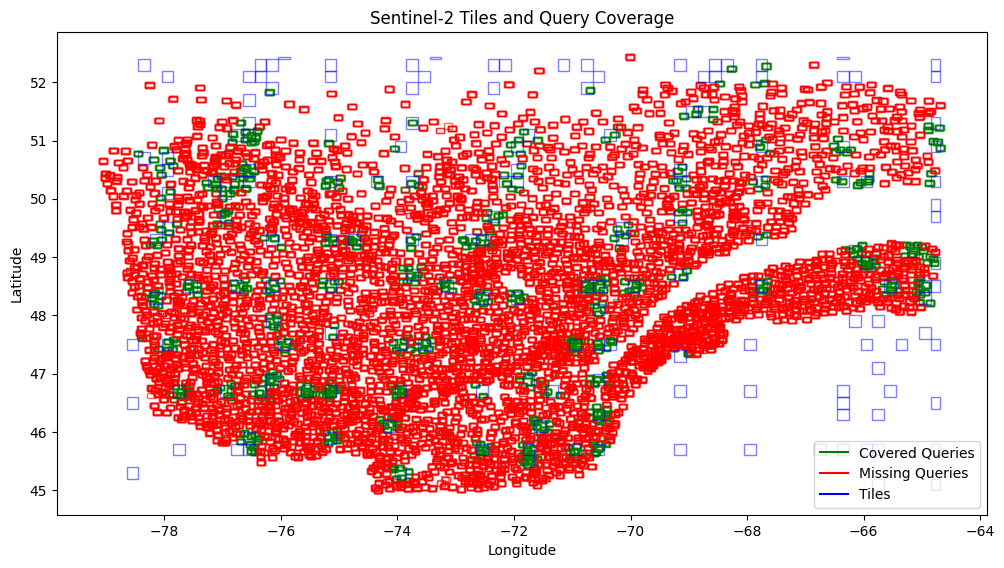

In [74]:
import pandas as pd
import rasterio
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchgeo.datasets import Sentinel2
from pyproj import Transformer

dataset = sentinel2_dataset
processed_species_original_locations.to_crs(dataset.crs, inplace=True)  # Ensure locations are in dataset CRS   
point_sampler = PointGeoSampler(
    dataset=dataset,
    locations=processed_species_original_locations.geometry,
    side_length_meters=10000
)
dataset_queries = point_sampler.get_all_queries()


# Convert raster bounds to GeoDataFrame in their CRS, and reproject to common CRS before concatenation
tile_gdfs = []
for fpath in dataset.files:
    with rasterio.open(fpath) as src:
        tile_box = box(*src.bounds)
        gdf_tile = gpd.GeoDataFrame(geometry=[tile_box], crs=src.crs)
        gdf_tile = gdf_tile.to_crs(dataset.crs)  # Reproject to dataset CRS
        tile_gdfs.append(gdf_tile)

# Concatenate all tiles (now all in dataset CRS)
tiles_gdf = gpd.GeoDataFrame(pd.concat(tile_gdfs, ignore_index=True), crs=dataset.crs)

# Function to plot queries and tiles
def plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    def add_bboxes(queries, color, label, fill=False):
        for q in queries:
            width = q.maxx - q.minx
            height = q.maxy - q.miny
            ax.add_patch(Rectangle(
                (q.minx, q.miny), width, height,
                fill=fill, edgecolor=color, linewidth=1, alpha=0.6
            ))
        ax.plot([], [], color=color, label=label)
    
    add_bboxes(covered_queries, "green", "Covered Queries")
    add_bboxes(missing_queries, "red", "Missing Queries")
    
    #Plot tile bounding boxes
    for geom in tiles_gdf.geometry:
        minx, miny, maxx, maxy = geom.bounds
        ax.add_patch(Rectangle(
            (minx, miny), maxx - minx, maxy - miny,
            fill=False, edgecolor="blue", linewidth=1, alpha=0.5
        ))
    ax.plot([], [], color="blue", label="Tiles")
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Sentinel-2 Tiles and Query Coverage")
    ax.legend()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Example usage
covered_queries = [q for q in dataset_queries if q not in missing_queries]
plot_query_and_tile_bboxes(covered_queries, missing_queries, tiles_gdf)


In [79]:
#export as shapefile the bounding box of sentinel2 dataset
import geopandas as gpd

from shapely.geometry import box

# Convert dataset.bounds (BoundingBox) to a shapely box
bbox_geom = box(dataset.bounds.minx, dataset.bounds.miny, dataset.bounds.maxx, dataset.bounds.maxy)
bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs=dataset.crs)

# Export to shapefile
bbox.to_file("sentinel2_bbox.shp")

In [12]:
# Transformer from EPSG:32617 -> EPSG:4326
transformer = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)
#convert missing_queries to a dictionary format
bboxes_dict = {"EPSG:32617": []}
for bbox in missing_queries:
    bboxes_dict["EPSG:32617"].append({
        "minx": bbox.minx,
        "miny": bbox.miny,
        "maxx": bbox.maxx,
        "maxy": bbox.maxy,
        "mint": bbox.mint,
        "maxt": bbox.maxt
    })
# Convert all bounding boxes dynamically
bboxes_4326 = []
for bbox in bboxes_dict["EPSG:32617"]:
    min_lon, min_lat = transformer.transform(bbox["minx"], bbox["miny"])
    max_lon, max_lat = transformer.transform(bbox["maxx"], bbox["maxy"])
    
    # Create shapely box and store time info
    shapely_box = box(min_lon, min_lat, max_lon, max_lat)
    bboxes_4326.append(list(shapely_box.exterior.coords))

# Example: print the first converted box
bboxes_4326

[[(-78.33440890189017, 47.62147461407378),
  (-78.33440890189017, 47.708345695663866),
  (-78.47192912113702, 47.708345695663866),
  (-78.47192912113702, 47.62147461407378),
  (-78.33440890189017, 47.62147461407378)],
 [(-78.33578559566013, 47.622520800100716),
  (-78.33578559566013, 47.709393510591184),
  (-78.47330642041314, 47.709393510591184),
  (-78.47330642041314, 47.622520800100716),
  (-78.33578559566013, 47.622520800100716)],
 [(-78.33674242970679, 47.62321323332924),
  (-78.33674242970679, 47.710087078075645),
  (-78.47426358174714, 47.710087078075645),
  (-78.47426358174714, 47.62321323332924),
  (-78.33674242970679, 47.62321323332924)],
 [(-78.33800011420915, 47.62419549051326),
  (-78.33800011420915, 47.71107082172527),
  (-78.47552189072819, 47.71107082172527),
  (-78.47552189072819, 47.62419549051326),
  (-78.33800011420915, 47.62419549051326)]]

In [ ]:
#count the unique tiles in data_dir_sentinel2
import os
def count_unique_tiles(data_dir: str):
    """
    Counts unique Sentinel-2 tiles in the specified directory.

    Args:
        data_dir (str): Path to the directory containing Sentinel-2 data.

    Returns:
        int: Number of unique tiles found.
    """
    unique_tiles = set()
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.tif'):
                # Extract tile name from the file name
                tile_name = file.split('_')[0]  # Assuming tile name is the first part before '_'
                print(f"Found tile: {tile_name}")
                unique_tiles.add(tile_name)
    return len(unique_tiles)
# Count unique tiles in the Sentinel-2 data directory
unique_tile_count = count_unique_tiles(data_dir_sentinel2)
print(f"Number of unique Sentinel-2 tiles: {unique_tile_count}")

Found tile: T19UCR
Found tile: T19UDP
Found tile: T17TQM
Found tile: T19UGR
Found tile: T19UEU
Found tile: T19UEU
Found tile: T18TUR
Found tile: T19UCR
Found tile: T20UMB
Found tile: T18TYQ
Found tile: T18UVB
Found tile: T17UPT
Found tile: T18TWR
Found tile: T18TVR
Found tile: T18TVT
Found tile: T19UDR
Found tile: T18TUR
Found tile: T19UCU
Found tile: T18UYC
Found tile: T17TPM
Found tile: T19UGQ
Found tile: T19UEU
Found tile: T17UQQ
Found tile: T19UGR
Found tile: T19UCT
Found tile: T19TCM
Found tile: T18UYD
Found tile: T19UCP
Found tile: T18UWC
Found tile: T19TDL
Found tile: T20ULV
Found tile: T18UUU
Found tile: T18TUS
Found tile: T19UEP
Found tile: T17UQQ
Found tile: T18TYR
Found tile: T18TXT
Found tile: T19UDP
Found tile: T18TYS
Found tile: T19UGQ
Found tile: T20ULU
Found tile: T20UMB
Found tile: T18TWR
Found tile: T17TPM
Found tile: T18TUS
Found tile: T19UFU
Found tile: T19UCU
Found tile: T19UDR
Found tile: T18TWR
Found tile: T18UVB
Found tile: T17UQT
Found tile: T17TQM
Found tile: 

In [6]:
import ee
import geemap
import geopandas as gpd

# Assurez-vous d'avoir initialisé Earth Engine
ee.Authenticate()
ee.Initialize()

# Supposons que votre GeoDataFrame soit nommé 'gdf'
# Convertissez le GeoDataFrame en une FeatureCollection Earth Engine
points_ee = geemap.geopandas_to_ee(processed_species_original_locations.iloc[:5])

def create_square_aoi(feature):
    # Get the centroid of the feature's geometry.
    center = feature.geometry().centroid()

    # Create a 5000m buffer around the center.
    # Earth Engine will automatically use a local projected coordinate system
    # to perform the calculation, ensuring the distance is accurate in meters.
    aoi_circle = center.buffer(5000)

    # Get the bounding box of the circular buffer to create a square.
    aoi_square = aoi_circle.bounds()

    # Return the square as a new feature.
    return ee.Feature(aoi_square)

# Apply the function to your collection of points.
aois_squares = points_ee.map(create_square_aoi)
# Convert the resulting FeatureCollection to a GeoDataFrame



In [94]:
# WorldClim V1 Bioclim
bio = ee.Image("WORLDCLIM/V1/BIO")

In [7]:
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2024-06-01', '2024-09-01') \
    .filterBounds(aois_squares) \
    .median() \
    .select(['SR_B2', 'SR_B3', 'SR_B4'], ['blue', 'green', 'red']) # sélectionnez les bandes qui vous intéressent



Raster shape: (9, 334, 484)
Available bands:
  Band 1: blue
  Band 2: green
  Band 3: red
  Band 4: nir
  Band 5: swir1
  Band 6: swir2
  Band 7: ndvi
  Band 8: ndwi
  Band 9: evi


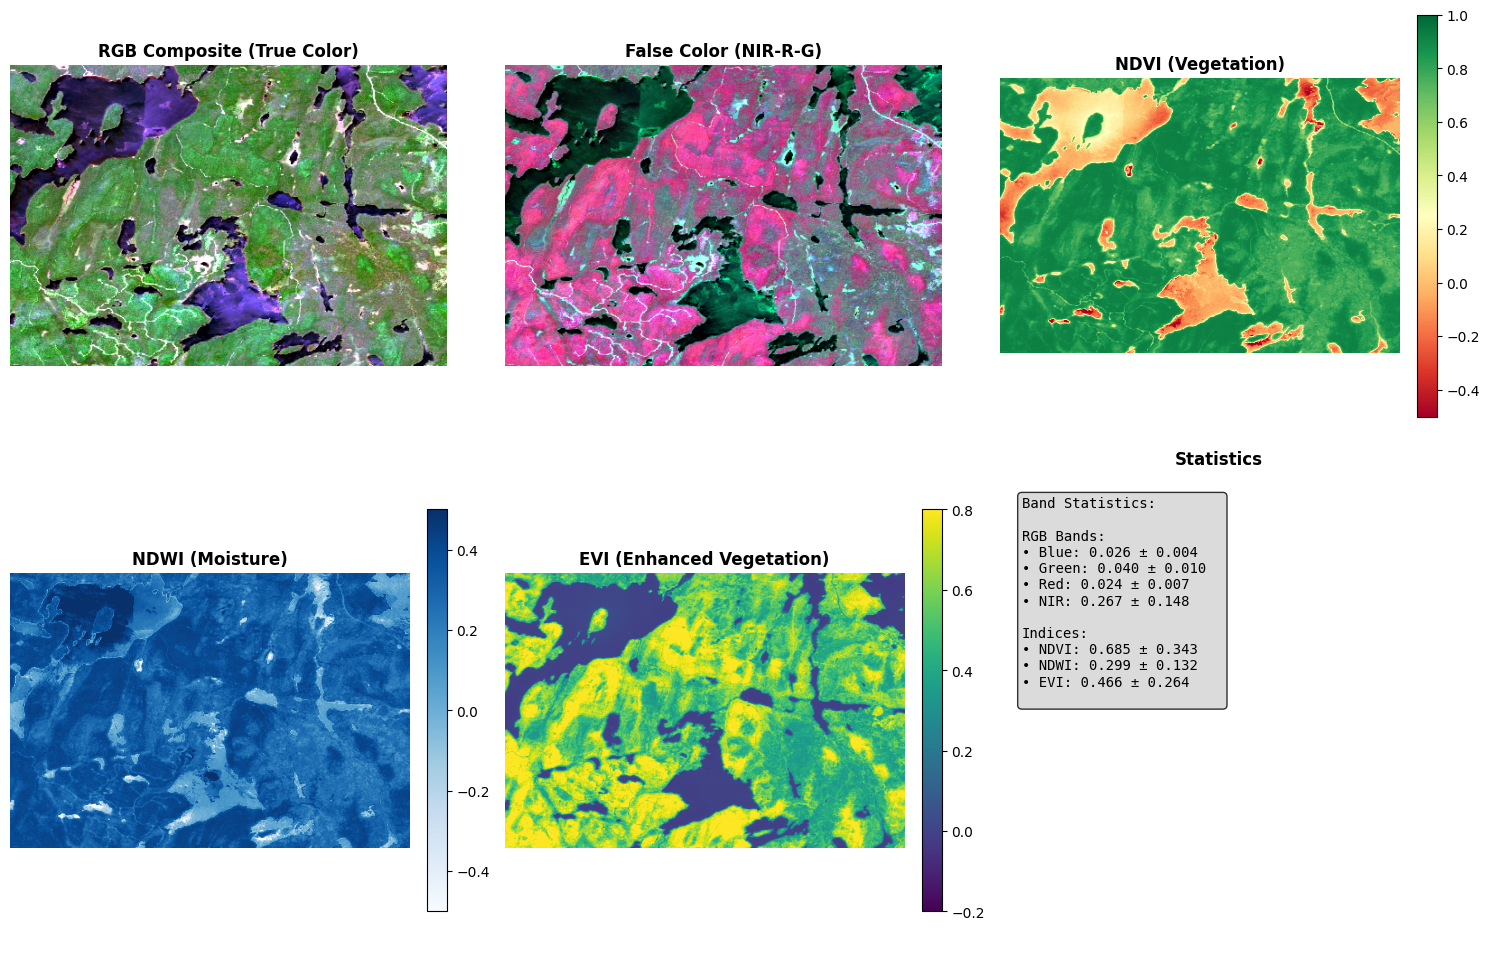


Image dimensions: 334 x 484 pixels
Pixel size: | 0.00, 0.00,-78.30|
| 0.00,-0.00, 46.66|
| 0.00, 0.00, 1.00|
CRS: EPSG:4326


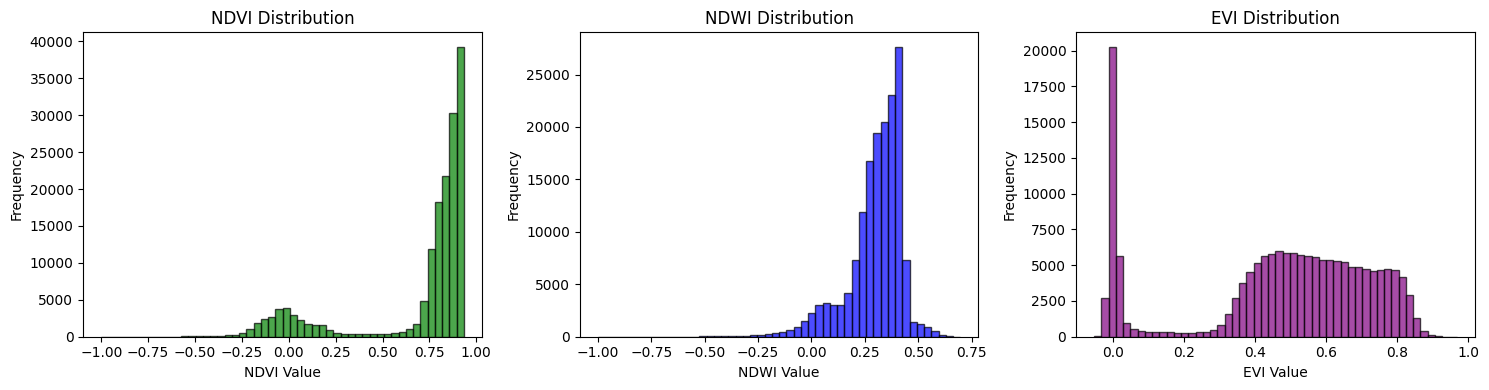

In [44]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the raster data from a .tif file
tif_path = "../data/sentinel2_tiles_normalized/s2_-78.23343_46.617181000000016_multiband.tif"
with rasterio.open(tif_path) as src:
    band_data = src.read()  # shape: (bands, height, width) for multi-band
    print(f"Raster shape: {band_data.shape}")
    metadata = src.meta

# Band order from our export:
# Band 1: blue, Band 2: green, Band 3: red, Band 4: nir, 
# Band 5: swir1, Band 6: swir2, Band 7: ndvi, Band 8: ndwi, Band 9: evi
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi', 'evi']

print("Available bands:")
for i, name in enumerate(band_names[:band_data.shape[0]]):
    print(f"  Band {i+1}: {name}")

def robust_normalize(band, percentile_range=(2, 98)):
    """Normalize band using percentile clipping to handle outliers"""
    # Remove NaN values for percentile calculation
    valid_pixels = band[~np.isnan(band)]
    if len(valid_pixels) == 0:
        return np.zeros_like(band)
    
    # Use percentile clipping for better visualization
    p_low, p_high = np.percentile(valid_pixels, percentile_range)
    normalized = np.clip((band - p_low) / (p_high - p_low), 0, 1)
    return normalized

def create_rgb_composite(red_band, green_band, blue_band):
    """Create RGB composite with proper normalization"""
    # Normalize each band independently
    red_norm = robust_normalize(red_band)
    green_norm = robust_normalize(green_band)  
    blue_norm = robust_normalize(blue_band)
    
    # Stack into RGB
    rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return rgb

def visualize_sentinel2_data(band_data, band_names):
    """Visualize RGB composite, NDVI, NDWI, and EVI"""
    
    # Check if we have the required bands
    if band_data.shape[0] < 9:
        print(f"Warning: Expected 9 bands, got {band_data.shape[0]}")
    
    # Extract specific bands (0-indexed)
    blue = band_data[0]    # Band 1: blue
    green = band_data[1]   # Band 2: green  
    red = band_data[2]     # Band 3: red
    nir = band_data[3]     # Band 4: nir
    ndvi = band_data[6]    # Band 7: ndvi
    ndwi = band_data[7]    # Band 8: ndwi (moisture)
    evi = band_data[8]     # Band 9: evi
    
    # Create RGB composite
    rgb_composite = create_rgb_composite(red, green, blue)
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # RGB Composite
    axes[0, 0].imshow(rgb_composite)
    axes[0, 0].set_title('RGB Composite (True Color)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # False Color Composite (NIR, Red, Green) - good for vegetation
    false_color = create_rgb_composite(nir, red, green)
    axes[0, 1].imshow(false_color)
    axes[0, 1].set_title('False Color (NIR-R-G)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # NDVI
    ndvi_display = np.clip(ndvi, -1, 1)  # NDVI should be between -1 and 1
    im_ndvi = axes[0, 2].imshow(ndvi_display, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0, 2].set_title('NDVI (Vegetation)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im_ndvi, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # NDWI (Moisture)
    ndwi_display = np.clip(ndwi, -1, 1)  # NDWI should be between -1 and 1
    im_ndwi = axes[1, 0].imshow(ndwi_display, cmap='Blues', vmin=-0.5, vmax=0.5)
    axes[1, 0].set_title('NDWI (Moisture)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im_ndwi, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # EVI
    evi_display = np.clip(evi, -1, 1)  # EVI typically ranges from -1 to 1
    im_evi = axes[1, 1].imshow(evi_display, cmap='viridis', vmin=-0.2, vmax=0.8)
    axes[1, 1].set_title('EVI (Enhanced Vegetation)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im_evi, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # Individual band statistics
    stats_text = f"""Band Statistics:
    
RGB Bands:
• Blue: {np.nanmean(blue):.3f} ± {np.nanstd(blue):.3f}
• Green: {np.nanmean(green):.3f} ± {np.nanstd(green):.3f}  
• Red: {np.nanmean(red):.3f} ± {np.nanstd(red):.3f}
• NIR: {np.nanmean(nir):.3f} ± {np.nanstd(nir):.3f}

Indices:
• NDVI: {np.nanmean(ndvi):.3f} ± {np.nanstd(ndvi):.3f}
• NDWI: {np.nanmean(ndwi):.3f} ± {np.nanstd(ndwi):.3f}
• EVI: {np.nanmean(evi):.3f} ± {np.nanstd(evi):.3f}
    """
    
    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 2].set_title('Statistics', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some diagnostic info
    print(f"\nImage dimensions: {red.shape[0]} x {red.shape[1]} pixels")
    print(f"Pixel size: {metadata.get('transform', 'Unknown')}")
    print(f"CRS: {metadata.get('crs', 'Unknown')}")

# Visualize the data
visualize_sentinel2_data(band_data, band_names)

# Optional: Create a simple histogram of index values
def plot_index_histograms(band_data):
    """Plot histograms of the vegetation indices"""
    if band_data.shape[0] >= 9:
        ndvi = band_data[6].flatten()
        ndwi = band_data[7].flatten()
        evi = band_data[8].flatten()
        
        # Remove NaN values
        ndvi = ndvi[~np.isnan(ndvi)]
        ndwi = ndwi[~np.isnan(ndwi)]
        evi = evi[~np.isnan(evi)]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        axes[0].hist(ndvi, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0].set_title('NDVI Distribution')
        axes[0].set_xlabel('NDVI Value')
        axes[0].set_ylabel('Frequency')
        
        axes[1].hist(ndwi, bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[1].set_title('NDWI Distribution')
        axes[1].set_xlabel('NDWI Value')
        axes[1].set_ylabel('Frequency')
        
        axes[2].hist(evi, bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[2].set_title('EVI Distribution')
        axes[2].set_xlabel('EVI Value')
        axes[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Create histograms
plot_index_histograms(band_data)

In [33]:
band_data

array([[0.83777654, 0.8393658 , 0.8400077 , ..., 0.344571  , 0.344571  ,
        0.30841658],
       [0.84323317, 0.83695734, 0.81486344, ..., 0.3740062 , 0.3740062 ,
        0.30841658],
       [0.8322381 , 0.8221207 , 0.8142475 , ..., 0.38944513, 0.41072315,
        0.36876586],
       ...,
       [0.8609025 , 0.8609025 , 0.8555516 , ..., 0.82277924, 0.82277924,
        0.8071045 ],
       [0.8530386 , 0.8530386 , 0.8479482 , ..., 0.8151421 , 0.8151421 ,
        0.7801258 ],
       [0.84505904, 0.84505904, 0.84714484, ..., 0.8098785 , 0.8098785 ,
        0.7847843 ]], dtype=float32)

In [53]:
import ee
import geemap
import pickle
import os

# Auth & init
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

def mask_s2_clouds(image):
    """Mask clouds in Sentinel-2 using QA60 band and SCL"""
    qa = image.select('QA60')
    scl = image.select('SCL')
    
    # QA60 bits 10 and 11 are clouds and cirrus
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    
    # Create masks
    qa_mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
              qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    
    # SCL mask: keep vegetation(4), not_vegetated(5), water(6), snow_ice(11)
    # Remove clouds(9), cloud_shadows(3), cirrus(10)
    scl_mask = scl.neq(9).And(scl.neq(3)).And(scl.neq(10)).And(scl.neq(8))  # 8 = cloud medium probability
    
    return image.updateMask(qa_mask.And(scl_mask))

def add_indices(image):
    """Add vegetation and moisture indices"""
    # NDVI using Sentinel-2 bands
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # NDWI (moisture) using NIR and SWIR
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    
    # EVI (Enhanced Vegetation Index) - often better than NDVI
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000), 
            'BLUE': image.select('B2').divide(10000)
        }).rename('EVI')
    
    return image.addBands([ndvi, ndwi, evi])

def save_progress(current_index, total_count, progress_file="s2_progress.pkl"):
    """Save current progress"""
    progress = {
        'current_index': current_index,
        'total_count': total_count,
        'processed_ids': []  # Could add this later if needed
    }
    with open(progress_file, 'wb') as f:
        pickle.dump(progress, f)
    print(f"Progress saved: {current_index}/{total_count}")

def load_progress(progress_file="s2_progress.pkl"):
    """Load previous progress"""
    if os.path.exists(progress_file):
        with open(progress_file, 'rb') as f:
            progress = pickle.load(f)
        print(f"Resuming from: {progress['current_index']}/{progress['total_count']}")
        return progress['current_index']
    else:
        print("No previous progress found, starting from beginning")
        return 0

def process_sentinel2_with_resume(processed_species_original_locations, start_index=None):
    """Process Sentinel-2 data with simple resume capability"""
    
    # Load progress or use provided start_index
    if start_index is None:
        start_index = load_progress()
    
    total_count = len(processed_species_original_locations)
    print(f"Processing {total_count - start_index} locations (starting from index {start_index})")
    
    # Sentinel-2 Surface Reflectance collection
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate('2024-06-01', '2024-09-01')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
          .map(mask_s2_clouds)
          .map(add_indices))
    
    # Start processing from the saved index
    for i, (_, row) in enumerate(processed_species_original_locations.iloc[start_index:].iterrows(), start=start_index):
        feature_id = str(row['id'])
        lon, lat = row['geometry'].x, row['geometry'].y
        
        print(f"\n[{i+1}/{total_count}] Processing {feature_id} at ({lat:.4f}, {lon:.4f})")
        
        try:
            # Create AOI (10km x 10km)
            aoi = ee.Geometry.Point([lon, lat]).buffer(5000).bounds()
            
            # Filter collection for this location
            s2_filtered = s2.filterBounds(aoi)
            
            # Check available images
            count = s2_filtered.size().getInfo()
            print(f"  Found {count} Sentinel-2 images")
            
            if count == 0:
                print(f"  No suitable images found for {feature_id}")
                save_progress(i + 1, total_count)  # Save progress even for skipped
                continue
            
            # Create composite - median works well for Sentinel-2
            composite = s2_filtered.median().clip(aoi)
            
            # Convert to 0-1 scale (Sentinel-2 is in 0-10000 range) and ensure Float32
            optical_bands = composite.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']).divide(10000).toFloat()
            indices = composite.select(['NDVI', 'NDWI', 'EVI']).toFloat()
            
            # Create single multi-band image with renamed bands for clarity
            multi_band_image = (optical_bands.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
                               .rename(['blue', 'green', 'red', 'nir', 'swir1', 'swir2'])
                               .addBands(indices.select(['NDVI', 'NDWI', 'EVI'])
                                        .rename(['ndvi', 'ndwi', 'evi']))
                               .toFloat())  # Ensure final image is Float32
            
            print(f"  Exporting 9-band composite at 30m resolution...")
            
            # Single export with all bands
            task = ee.batch.Export.image.toDrive(
                image=multi_band_image,
                description=f"s2_{feature_id}_multiband",
                folder='EE_Export_Data',
                fileNamePrefix=f"s2_{feature_id}_multiband",
                region=aoi,
                scale=30,  # Resample everything to 30m
                crs='EPSG:4326',
                maxPixels=1e9,
                fileFormat='GeoTIFF'
            )
            task.start()
            
            print(f"  ✓ Task submitted for {feature_id}")
            print(f"    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi")
            
            # Save progress after each successful submission
            save_progress(i + 1, total_count)
            
        except Exception as e:
            print(f"  ❌ Error processing {feature_id}: {str(e)}")
            print(f"  Saving progress at index {i} and stopping")
            save_progress(i, total_count)  # Save current position (not +1 since this one failed)
            
            # Print resume instructions
            print(f"\n=== RESUME INSTRUCTIONS ===")
            print(f"To resume from where you left off, run:")
            print(f"process_sentinel2_with_resume(processed_species_original_locations, start_index={i})")
            
            # Re-raise the exception so you can see what went wrong
            raise e
    
    print(f"\n✅ All processing complete! Processed {total_count - start_index} locations")
    
    # Clean up progress file when done
    if os.path.exists("s2_progress.pkl"):
        os.remove("s2_progress.pkl")
        print("Progress file cleaned up")

# === USAGE ===

# First run (starts from beginning):
# process_sentinel2_with_resume(processed_species_original_locations)

# Resume after crash (automatically loads saved progress):
# process_sentinel2_with_resume(processed_species_original_locations)

# Resume from specific index:
process_sentinel2_with_resume(processed_species_original_locations, start_index=3161)

print("=== READY TO PROCESS ===")
print("Run: process_sentinel2_with_resume(processed_species_original_locations)")
print("If it crashes, just run the same command again to resume from where it stopped")

Processing 21799 locations (starting from index 3161)

[3162/24960] Processing -72.130668_46.509060000000005 at (46.5091, -72.1307)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.130668_46.509060000000005
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3162/24960

[3163/24960] Processing -72.133387_46.50401800000001 at (46.5040, -72.1334)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.133387_46.50401800000001
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3163/24960

[3164/24960] Processing -72.053482_46.39665400000001 at (46.3967, -72.0535)
  Found 9 Sentinel-2 images
  Exporting 9-band composite at 30m resolution...
  ✓ Task submitted for -72.053482_46.39665400000001
    Bands: blue, green, red, nir, swir1, swir2, ndvi, ndwi, evi
Progress saved: 3164/24960

[3165/24960] Processing -72.053164_46.39933100000

EEException: Too many tasks already in the queue (3000, limit 3000).

In [13]:
import os
import re

def find_missing_tiles(folder):
    # Regex to extract tile number
    pattern = re.compile(r"S2_LARGE_tile_(\d+)\.tif$")

    # Collect all found tile numbers
    tiles = []
    for fname in os.listdir(folder):
        match = pattern.match(fname)
        if match:
            tiles.append(int(match.group(1)))

    if not tiles:
        print("No tiles found.")
        return []

    tiles = sorted(set(tiles))
    min_tile, max_tile = tiles[0], tiles[-1]

    # Expected full range
    full_range = set(range(min_tile, max_tile + 1))

    # Missing tiles
    missing = sorted(full_range - set(tiles))

    return missing

# Example usage
folder_path = "../data/sentinel2_tiles_ee"
missing_tiles = find_missing_tiles(folder_path)

if missing_tiles:
    print("Missing tiles:", missing_tiles)
else:
    print("No tiles missing.")


Missing tiles: [7, 8, 9, 17, 26, 34, 35, 44, 47, 48, 49, 50, 51, 53, 62, 71, 89, 90, 99, 100, 107, 108, 109, 117, 118, 119, 126, 127, 128, 134, 135, 136, 137, 141, 143, 144, 145, 146, 149]


In [20]:
import os
import io
import time
from pathlib import Path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

# Google Drive API scopes
SCOPES = ['https://www.googleapis.com/auth/drive']

def authenticate_drive():
    """Authenticate with Google Drive API"""
    creds = None
    
    # Check for existing token
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    
    # If there are no (valid) credentials available, let the user log in
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # You'll need to download credentials.json from Google Cloud Console
            if not os.path.exists('credentials.json'):
                print("ERROR: credentials.json not found!")
                print("1. Go to Google Cloud Console")
                print("2. Enable Drive API")  
                print("3. Create OAuth2 credentials")
                print("4. Download as 'credentials.json' in this directory")
                return None
            
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        
        # Save credentials for next run
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    
    return build('drive', 'v3', credentials=creds)

def find_ee_export_folders(service, target_folder_name="EE_Export_Data"):
    """Find all EE_Large_Tiles folders in Google Drive"""
    query = f"name='{target_folder_name}' and mimeType='application/vnd.google-apps.folder'"

    try:
        results = service.files().list(q=query, fields="files(id, name, parents)").execute()
        folders = results.get('files', [])

        print(f"Found {len(folders)} {target_folder_name} folders")
        return folders
        
    except Exception as e:
        print(f"Error finding folders: {e}")
        return []

def get_files_in_folder(service, folder_id):
    """Get all .tif files in a folder"""
    query = f"parents in '{folder_id}' and name contains '.tif'"
    
    try:
        results = service.files().list(
            q=query, 
            fields="files(id, name, size, createdTime, modifiedTime)"
        ).execute()
        files = results.get('files', [])
        
        return files
        
    except Exception as e:
        print(f"Error getting files from folder {folder_id}: {e}")
        return []

def is_file_ready(file_info, min_size_mb=0.1):
    """Check if file is ready for download (has reasonable size and is not being modified)"""
    try:
        size_mb = int(file_info.get('size', 0)) / (1024 * 1024)
        
        # Check minimum size (empty files are likely still processing)
        if size_mb < min_size_mb:
            return False, f"Too small ({size_mb:.2f} MB)"
        
        # Check if file was recently modified (might still be uploading)
        created_time = file_info.get('createdTime', '')
        modified_time = file_info.get('modifiedTime', '')
        
        if created_time != modified_time:
            # File was modified after creation, might still be processing
            from datetime import datetime, timezone
            try:
                mod_time = datetime.fromisoformat(modified_time.replace('Z', '+00:00'))
                now = datetime.now(timezone.utc)
                minutes_since_mod = (now - mod_time).total_seconds() / 60
                
                if minutes_since_mod < 2:  # Modified in last 2 minutes
                    return False, f"Recently modified ({minutes_since_mod:.1f} min ago)"
            except:
                pass
        
        return True, f"Ready ({size_mb:.2f} MB)"
        
    except Exception as e:
        return False, f"Error checking: {e}"

def download_file(service, file_id, filename, local_dir):
    """Download a file from Google Drive"""
    local_path = Path(local_dir) / filename
    
    # Skip if already downloaded
    if local_path.exists():
        print(f"    ✓ Already exists locally: {filename}")
        return True, str(local_path)
    
    try:
        request = service.files().get_media(fileId=file_id)
        
        with open(local_path, 'wb') as local_file:
            downloader = MediaIoBaseDownload(local_file, request)
            done = False
            
            while done is False:
                status, done = downloader.next_chunk()
                if status:
                    progress = int(status.progress() * 100)
                    print(f"    Downloading {filename}: {progress}%", end='\r')
        
        print(f"    ✓ Downloaded: {filename}")
        return True, str(local_path)
        
    except Exception as e:
        print(f"    ❌ Download failed: {filename} - {e}")
        return False, None

def delete_file_from_drive(service, file_id, filename):
    """Delete a file from Google Drive"""
    try:
        service.files().delete(fileId=file_id).execute()
        print(f"    🗑️  Deleted from Drive: {filename}")
        return True
    except Exception as e:
        print(f"    ❌ Delete failed: {filename} - {e}")
        return False

def delete_empty_folder(service, folder_id, folder_name="EE_Large_Tiles"):
    """Delete folder if it's empty"""
    try:
        # Check if folder is empty
        files = get_files_in_folder(service, folder_id)
        if len(files) == 0:
            service.files().delete(fileId=folder_id).execute()
            print(f"    🗑️  Deleted empty folder: {folder_name}")
            return True
        else:
            print(f"    📁 Folder not empty ({len(files)} files remaining): {folder_name}")
            return False
    except Exception as e:
        print(f"    ❌ Error deleting folder: {e}")
        return False

def download_sentinel2_tiles(local_directory="./sentinel2_tiles", 
                           delete_after_download=True,
                           delete_empty_folders=True,
                           wait_for_ready=True,
                           max_wait_minutes=10,
                           target_folder_name="EE_Export_Data"):
    """
    Download all Sentinel-2 tiles from Google Drive EE_Export_Data folders
    
    Args:
        local_directory: Where to save tiles locally
        delete_after_download: Delete files from Drive after downloading
        delete_empty_folders: Delete empty EE_Export_Data folders
        wait_for_ready: Wait for files that aren't ready yet
        max_wait_minutes: Max time to wait for files to be ready
    """
    
    print("=== SENTINEL-2 TILE DOWNLOADER ===")
    
    # Create local directory
    Path(local_directory).mkdir(parents=True, exist_ok=True)
    print(f"Local directory: {os.path.abspath(local_directory)}")
    
    # Authenticate with Google Drive
    print("\nAuthenticating with Google Drive...")
    service = authenticate_drive()
    if not service:
        return
    
    print("✓ Authenticated successfully")
    
    # Find all EE_Export_Data folders
    print("\nSearching for EE_Export_Data folders...")
    folders = find_ee_export_folders(service, target_folder_name=target_folder_name)

    if not folders:
        print(f"No {target_folder_name} folders found!")
        return
    
    # Process each folder
    total_downloaded = 0
    total_deleted = 0
    folders_deleted = 0
    
    for folder in folders:
        folder_id = folder['id']
        folder_name = folder['name']
        
        print(f"\n=== Processing folder: {folder_name} (ID: {folder_id}) ===")
        
        # Get all .tif files in this folder
        files = get_files_in_folder(service, folder_id)
        print(f"Found {len(files)} .tif files")
        
        if not files:
            if delete_empty_folders:
                delete_empty_folder(service, folder_id, folder_name)
                folders_deleted += 1
            continue
        
        # Check which files are ready
        ready_files = []
        waiting_files = []
        
        for file_info in files:
            is_ready, status = is_file_ready(file_info)
            filename = file_info['name']
            
            if is_ready:
                ready_files.append(file_info)
                print(f"  ✓ Ready: {filename} - {status}")
            else:
                waiting_files.append(file_info)
                print(f"  ⏳ Waiting: {filename} - {status}")
        
        # Wait for files that aren't ready yet
        if waiting_files and wait_for_ready:
            print(f"\nWaiting for {len(waiting_files)} files to be ready...")
            
            wait_start = time.time()
            max_wait_seconds = max_wait_minutes * 60
            
            while waiting_files and (time.time() - wait_start) < max_wait_seconds:
                time.sleep(30)  # Check every 30 seconds
                
                still_waiting = []
                for file_info in waiting_files:
                    # Re-check file status
                    updated_files = get_files_in_folder(service, folder_id)
                    updated_file = next((f for f in updated_files if f['id'] == file_info['id']), None)
                    
                    if updated_file:
                        is_ready, status = is_file_ready(updated_file)
                        filename = updated_file['name']
                        
                        if is_ready:
                            ready_files.append(updated_file)
                            print(f"  ✓ Now ready: {filename} - {status}")
                        else:
                            still_waiting.append(updated_file)
                
                waiting_files = still_waiting
                elapsed_min = (time.time() - wait_start) / 60
                print(f"  Still waiting for {len(waiting_files)} files ({elapsed_min:.1f}/{max_wait_minutes} min)")
        
        # Download ready files
        if ready_files:
            print(f"\nDownloading {len(ready_files)} ready files...")
            
            for file_info in ready_files:
                filename = file_info['name']
                file_id = file_info['id']
                
                # Download file
                success, local_path = download_file(service, file_id, filename, local_directory)
                if success:
                    total_downloaded += 1
                
                    # Delete from Drive if requested
                    if delete_after_download:
                        if delete_file_from_drive(service, file_id, filename):
                            total_deleted += 1
                
                # Small delay to avoid rate limits
                time.sleep(0.5)
        
        # Delete empty folder if requested
        if delete_empty_folders:
            remaining_files = get_files_in_folder(service, folder_id)
            if len(remaining_files) == 0:
                if delete_empty_folder(service, folder_id, folder_name):
                    folders_deleted += 1
    
    # Summary
    print(f"\n=== SUMMARY ===")
    print(f"Files downloaded: {total_downloaded}")
    print(f"Files deleted from Drive: {total_deleted}")
    print(f"Empty folders deleted: {folders_deleted}")
    print(f"Local directory: {os.path.abspath(local_directory)}")
    
    # List downloaded files
    local_files = list(Path(local_directory).glob("*.tif"))
    print(f"Local .tif files: {len(local_files)}")
    
    if local_files:
        print("Sample files:")
        for f in sorted(local_files)[:5]:
            size_mb = f.stat().st_size / (1024 * 1024)
            print(f"  {f.name} ({size_mb:.1f} MB)")
        if len(local_files) > 5:
            print(f"  ... and {len(local_files) - 5} more")

# === USAGE EXAMPLES ===

download_sentinel2_tiles(local_directory="../data/sentinel2_tiles_ee",
                         delete_empty_folders=False,
                          delete_after_download=True,
                          wait_for_ready=False,
                          target_folder_name="EE_Large_Tiles")

=== SENTINEL-2 TILE DOWNLOADER ===
Local directory: /home/alexis/Documents/projets/species-dist/data/sentinel2_tiles_ee

Authenticating with Google Drive...
✓ Authenticated successfully

Searching for EE_Export_Data folders...
Found 94 EE_Large_Tiles folders

=== Processing folder: EE_Large_Tiles (ID: 1QYCMF2OVwAitgVVt0zX897P-zyz8LEol) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 1ljux9OMetnPMB0OWcE1HxO0gVfa_nY_H) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 17I_FJsmyrdS3rLt-YTk9jbCBeQtggLCj) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 1vR9zSaoj-QrJSleC2OMDsGqx3BTteT4N) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 1xGKCQEFVmoTWZsCKmvnv2--F_G1yzjJ6) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 1PhHgWwAAcaVhnJ_1i3GM7APgTRbEqoiX) ===
Found 0 .tif files

=== Processing folder: EE_Large_Tiles (ID: 1lupcd6Kkne4JfBP7cIb5aNL3L1GYV45D) ===
Found 0 .tif files

=== Processing folder: EE_

In [22]:
import os
from pathlib import Path
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

# Google Drive API scopes
SCOPES = ['https://www.googleapis.com/auth/drive']

def authenticate_drive():
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            if not os.path.exists('credentials.json'):
                raise FileNotFoundError("credentials.json not found!")
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    return build('drive', 'v3', credentials=creds)

def find_folders(service, folder_name="EE_Export_Data"):
    query = f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder'"
    results = service.files().list(q=query, fields="files(id, name)").execute()
    return results.get('files', [])

def delete_folder(service, folder_id, folder_name):
    try:
        service.files().delete(fileId=folder_id).execute()
        print(f"🗑️  Deleted folder: {folder_name} (ID: {folder_id})")
        return True
    except Exception as e:
        print(f"❌ Failed to delete folder {folder_name}: {e}")
        return False

def bulk_delete_error_folders(target_folder_name="EE_Export_Data"):
    service = authenticate_drive()
    while True:
        folders = find_folders(service, target_folder_name)
        print(f"Found {len(folders)} '{target_folder_name}' folders to delete.")

        deleted_count = 0
        for folder in folders:
            if delete_folder(service, folder['id'], folder['name']):
                deleted_count += 1

        if deleted_count == 0:
            print(f"✅ No more folders to delete.")
            break


    print(f"✅ Deleted {deleted_count} folders.")

# Example usage
bulk_delete_error_folders(target_folder_name="EE_Large_Tiles")


Found 94 'EE_Large_Tiles' folders to delete.
🗑️  Deleted folder: EE_Large_Tiles (ID: 1QYCMF2OVwAitgVVt0zX897P-zyz8LEol)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1ljux9OMetnPMB0OWcE1HxO0gVfa_nY_H)
🗑️  Deleted folder: EE_Large_Tiles (ID: 17I_FJsmyrdS3rLt-YTk9jbCBeQtggLCj)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1vR9zSaoj-QrJSleC2OMDsGqx3BTteT4N)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1xGKCQEFVmoTWZsCKmvnv2--F_G1yzjJ6)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1PhHgWwAAcaVhnJ_1i3GM7APgTRbEqoiX)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1lupcd6Kkne4JfBP7cIb5aNL3L1GYV45D)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1AAZjTC0orpZdENk_hVT7eYF9mZ7MrFFC)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1gDc7qCej7tYdjmUh9lYZGjrNjHV3TaAQ)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1PX2avmjhHXx3veG2RMHXFnH0E82evGYc)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1_w0taBVCpij_-1ubr5f1rUq_F6A_xvTJ)
🗑️  Deleted folder: EE_Large_Tiles (ID: 1W86tog87r_xgNwyIHR579vPiIbEWyEkS)
🗑️  Deleted folder: EE_Large_Tiles (ID: 192xRqeJP4tTVMw

In [16]:
import ee
import numpy as np
import pandas as pd
from shapely.geometry import Point, box
import geopandas as gpd

# Auth & init
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

def create_tile_grid(locations_df, tile_size_km=100, buffer_km=10):
    """
    Create a grid of large tiles that cover all your locations
    
    Args:
        locations_df: DataFrame with geometry column containing Points
        tile_size_km: Size of each tile in kilometers
        buffer_km: Buffer around locations to ensure coverage
    """
    
    # Get bounds of all locations
    bounds = locations_df.bounds
    
    # Add buffer
    min_x = bounds['minx'].min() - buffer_km/111  # Rough km to degrees conversion
    max_x = bounds['maxx'].max() + buffer_km/111
    min_y = bounds['miny'].min() - buffer_km/111
    max_y = bounds['maxy'].max() + buffer_km/111
    
    print(f"Study area bounds: ({min_x:.3f}, {min_y:.3f}) to ({max_x:.3f}, {max_y:.3f})")
    
    # Calculate grid dimensions
    tile_size_deg = tile_size_km / 111  # Rough conversion
    
    # Create grid
    tiles = []
    tile_id = 0
    
    x = min_x
    while x < max_x:
        y = min_y
        while y < max_y:
            # Create tile bounds
            tile_bounds = box(x, y, 
                            min(x + tile_size_deg, max_x), 
                            min(y + tile_size_deg, max_y))
            
            # Check if this tile contains any locations
            tile_gdf = gpd.GeoDataFrame([{'tile_id': tile_id, 'geometry': tile_bounds}], 
                                       crs=locations_df.crs)
            
            # Spatial join to see if any locations fall in this tile
            intersects = gpd.sjoin(locations_df, tile_gdf, how='inner', predicate='within')
            
            if len(intersects) > 0:
                tiles.append({
                    'tile_id': f"tile_{tile_id:03d}",
                    'bounds': tile_bounds.bounds,  # (minx, miny, maxx, maxy)
                    'geometry': tile_bounds,
                    'location_count': len(intersects),
                    'location_ids': intersects['id'].tolist() if 'id' in intersects.columns else []
                })
            
            tile_id += 1
            y += tile_size_deg
        x += tile_size_deg
    
    tiles_gdf = gpd.GeoDataFrame(tiles, crs=locations_df.crs)
    
    print(f"Created {len(tiles)} tiles covering {len(locations_df)} locations")
    print(f"Average locations per tile: {len(locations_df)/len(tiles):.1f}")
    
    return tiles_gdf

def export_large_sentinel2_tiles(tiles_gdf, 
                                export_scale=30, 
                                date_range=('2024-06-01', '2024-09-01'),
                                start_tile_number=None):
    """Export large Sentinel-2 tiles covering multiple locations"""
    
    # Same S2 processing functions as before
    def mask_s2_clouds(image):
        qa = image.select('QA60')
        scl = image.select('SCL')
        
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        
        qa_mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
                  qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        
        scl_mask = scl.neq(9).And(scl.neq(3)).And(scl.neq(10)).And(scl.neq(8))
        
        return image.updateMask(qa_mask.And(scl_mask))

    def add_indices(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
        
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8').divide(10000),
                'RED': image.select('B4').divide(10000), 
                'BLUE': image.select('B2').divide(10000)
            }).rename('EVI')
        
        return image.addBands([ndvi, ndwi, evi])
    
        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterDate(date_range[0], date_range[1])
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
          .map(mask_s2_clouds)
          .map(add_indices))

    print(f"Exporting {len(tiles_gdf)} large tiles...")

    tasks = []

    for idx, tile in tiles_gdf.iterrows():
        tile_id = tile['tile_id']  # e.g., "tile_046"
        tile_number = int(tile_id.split('_')[1])  # extract numeric part

        # Skip tiles if restarting
        if start_tile_number is not None and tile_number < start_tile_number:
            print(f"Skipping {tile_id} (already processed)")
            continue

        bounds = tile['bounds']
        location_count = tile['location_count']

        print(f"\nTile {tile_id}: {location_count} locations")
        print(f"  Bounds: {bounds}")

        aoi = ee.Geometry.Rectangle(bounds)
        s2_filtered = s2.filterBounds(aoi)
        count = s2_filtered.size().getInfo()

        if count == 0:
            print(f"  Skipping {tile_id} - no images")
            continue

        composite = s2_filtered.median().clip(aoi)

        optical_bands = composite.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']).divide(10000).toFloat()
        indices = composite.select(['NDVI', 'NDWI', 'EVI']).toFloat()

        multi_band_image = (optical_bands.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
                            .rename(['blue', 'green', 'red', 'nir', 'swir1', 'swir2'])
                            .addBands(indices.select(['NDVI', 'NDWI', 'EVI'])
                                     .rename(['ndvi', 'ndwi', 'evi']))
                            .toFloat())

        task = ee.batch.Export.image.toDrive(
            image=multi_band_image,
            description=f"S2_LARGE_{tile_id}",
            folder='EE_Large_Tiles',
            fileNamePrefix=f"S2_LARGE_{tile_id}",
            region=aoi,
            scale=export_scale,
            crs='EPSG:4326',
            maxPixels=1e9,
            fileFormat='GeoTIFF'
        )

        task.start()
        tasks.append({'tile_id': tile_id, 'task': task, 'location_count': location_count})

        print(f"  ✓ Export started for {tile_id}")

    print(f"\n✅ Started {len(tasks)} large tile exports")
    tiles_gdf.to_file('large_tiles_metadata.geojson', driver='GeoJSON')
    print("✓ Saved tile metadata to 'large_tiles_metadata.geojson'")
    return tasks

def estimate_efficiency_gains(locations_df, tile_size_km=100):
    """Estimate efficiency gains from using large tiles"""
    
    n_locations = len(locations_df)
    
    # Current approach
    current_exports = n_locations
    current_downloads = n_locations
    
    # Large tile approach
    tiles = create_tile_grid(locations_df, tile_size_km)
    large_exports = len(tiles)
    large_downloads = len(tiles)
    
    print(f"\n=== EFFICIENCY COMPARISON ===")
    print(f"Locations to process: {n_locations:,}")
    print(f"Tile size: {tile_size_km} km")
    print()
    print(f"CURRENT APPROACH (small tiles):")
    print(f"  Exports: {current_exports:,}")
    print(f"  Downloads: {current_downloads:,}")
    print()
    print(f"LARGE TILE APPROACH:")
    print(f"  Exports: {large_exports:,}")
    print(f"  Downloads: {large_downloads:,}")
    print()
    print(f"EFFICIENCY GAINS:")
    print(f"  Export reduction: {current_exports/large_exports:.1f}x fewer")
    print(f"  Download reduction: {current_downloads/large_downloads:.1f}x fewer")
    print(f"  Queue pressure: {large_exports/3000*100:.1f}% of queue limit")
    
    return tiles

# === USAGE EXAMPLES ===

print("=== LARGE TILE SENTINEL-2 PROCESSING ===")
print()
print("1. Estimate efficiency gains:")
print("   tiles = estimate_efficiency_gains(processed_species_original_locations)")
print()
print("2. Create and export large tiles:")
print("   tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)")
print("   tasks = export_large_sentinel2_tiles(tiles)")
print()
print("3. After download, crop to individual locations (next step)")

tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)
#
# tasks = export_large_sentinel2_tiles(tiles, start_tile_number=38)


=== LARGE TILE SENTINEL-2 PROCESSING ===

1. Estimate efficiency gains:
   tiles = estimate_efficiency_gains(processed_species_original_locations)

2. Create and export large tiles:
   tiles = create_tile_grid(processed_species_original_locations, tile_size_km=100)
   tasks = export_large_sentinel2_tiles(tiles)

3. After download, crop to individual locations (next step)
Study area bounds: (-79.236, 44.911) to (-64.437, 52.529)
Created 118 tiles covering 24960 locations
Average locations per tile: 211.5


In [23]:
tiles

tile_id                                             bounds  \
0    tile_002  (-79.23590709009008, 46.7126567117117, -78.335...   
1    tile_003  (-79.23590709009008, 47.6135576126126, -78.335...   
2    tile_004  (-79.23590709009008, 48.5144585135135, -78.335...   
3    tile_005  (-79.23590709009008, 49.415359414414404, -78.3...   
4    tile_006  (-79.23590709009008, 50.316260315315304, -78.3...   
..        ...                                                ...   
113  tile_142  (-65.72239357657647, 51.217161216216205, -64.8...   
114  tile_147  (-64.82149267567556, 47.6135576126126, -64.437...   
115  tile_148  (-64.82149267567556, 48.5144585135135, -64.437...   
116  tile_150  (-64.82149267567556, 50.316260315315304, -64.4...   
117  tile_151  (-64.82149267567556, 51.217161216216205, -64.4...   

                                              geometry  location_count  \
0    POLYGON ((-78.33501 46.71266, -78.33501 47.613...              33   
1    POLYGON ((-78.33501 47.61356, -78.33501 48.514...             115   
2    POLYGON ((-78.33501 48.51446, -78.33501 49.415...             129   
3    POLYGON ((-78.33501 49.41536, -78.33501 50.316...             137   
4    POLYGON ((-78.33501 50.31626, -78.33501 51.217...              72   
..                                                 ...             ...   
113  POLYGON ((-64.82149 51.21716, -64.82149 52.118...             110   
114  POLYGON ((-64.43712 47.61356, -64.43712 48.514...              12   
115  POLYGON ((-64.43712 48.51446, -64.43712 49.415...              53   
116  POLYGON ((-64.43712 50.31626, -64.43712 51.217...              43   
117  POLYGON ((-64.43712 51.21716, -64.43712 52.118...              10   

                                          location_ids  
0    [-78.389448_47.12890599999999, -78.391359_47.1...  
1    [-78.386597_47.61598100000002, -78.403226_47.6...  
2    [-78.442478_48.64102299999999, -78.44014_48.64...  
3    [-78.896246_49.475688999999996, -78.897301_49....  
4    [-78.373543_50.54416700000002, -78.37162_50.54...  
..                                                 ...  
113  [-65.707513_51.546592999999966, -65.703138_51....  
114  [-64.772134_48.34824199999998, -64.771765_48.3...  
115  [-64.71433_49.04255599999997, -64.717641_49.04...  
116  [-64.527209_51.11712800000001, -64.527737_51.1...  
117  [-64.683304_51.609131, -64.682101_51.608126000...  

[118 rows x 5 columns]

In [24]:
#count the files in folder
import os
def count_files_in_folder(folder_path):
    """Count the number of files in a folder"""
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return 0
    
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count
folder_path = "../data/sentinel2_tiles_ee"
count_files_in_folder(folder_path)

Number of files in '../data/sentinel2_tiles_ee': 118


118

In [ ]:
# find row with geometry.x = -72.130668
processed_species_original_locations[processed_species_original_locations['geometry'].x == -72.132175]

3160    POINT (-72.13218 46.50612)
Name: geometry, dtype: geometry

In [112]:
# Get the first square from your collection
first_square = aois_squares.first()

# Clip the predictors image to this square's boundary
clipped_image = bio.clip(first_square)

# Convert the clipped image to a NumPy array
# This might take some time depending on the size and bands of your data
import numpy as np
import geemap
image_array = geemap.ee_to_numpy(clipped_image)

# Check the shape of the array
# This should be (height, width, number of bands)
print(image_array.shape)

(12, 16, 19)


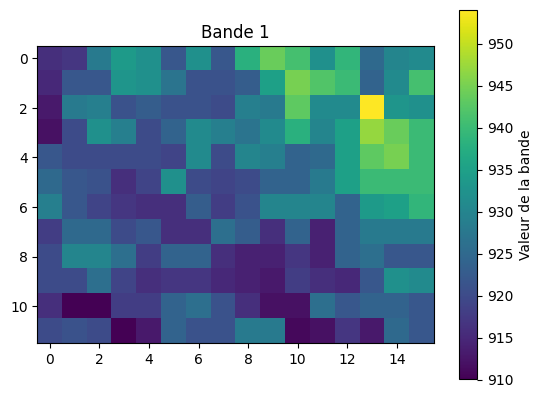

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que votre tableau NumPy se nomme image_array
# Affichez la première bande (indice 0)
plt.imshow(image_array[:, :, 11], cmap='viridis')
plt.title('Bande 1')
plt.colorbar(label='Valeur de la bande')
plt.show()

In [ ]:
sentinel2_dataset = SimpleRasterDataset(
    paths="../data/sentinel2_tiles_ee",
    all_bands=["blue", "green", "red", "nir", "swir1", "swir2", "ndvi", "ndwi", "evi"],
    transforms=None,
    crs="EPSG:4326"
)
point_geo_sampler = PointGeoSampler(
    sentinel2_dataset,
    processed_species_original_locations,
    side_length_meters=10000
)
print(f"Total points to sample: {len(point_geo_sampler)}")
queries = point_geo_sampler.get_all_queries()



Total points to sample: 24732


Sample shape: torch.Size([9, 333, 484])


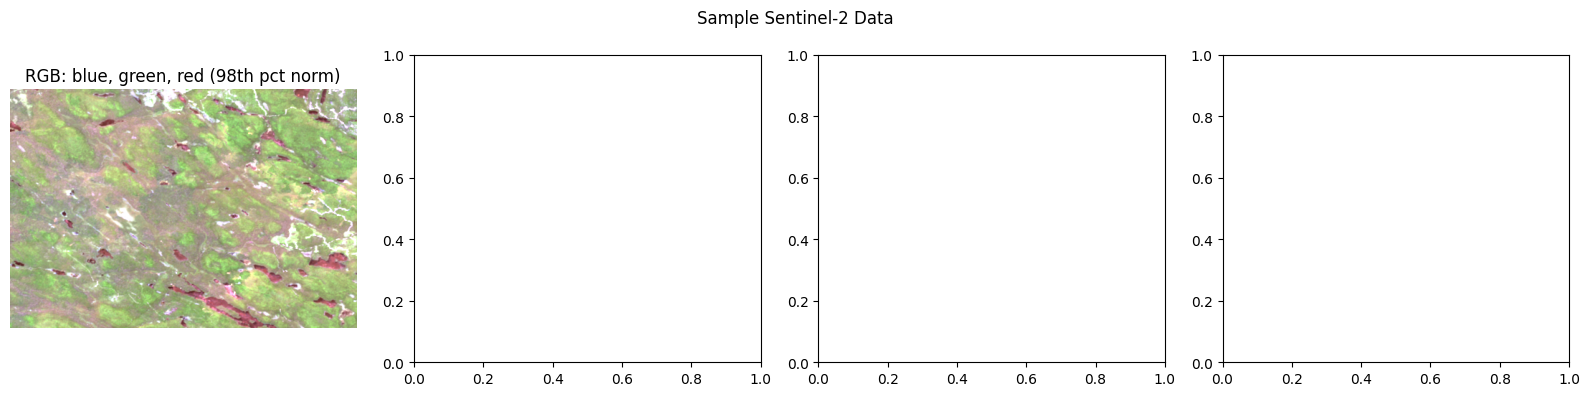

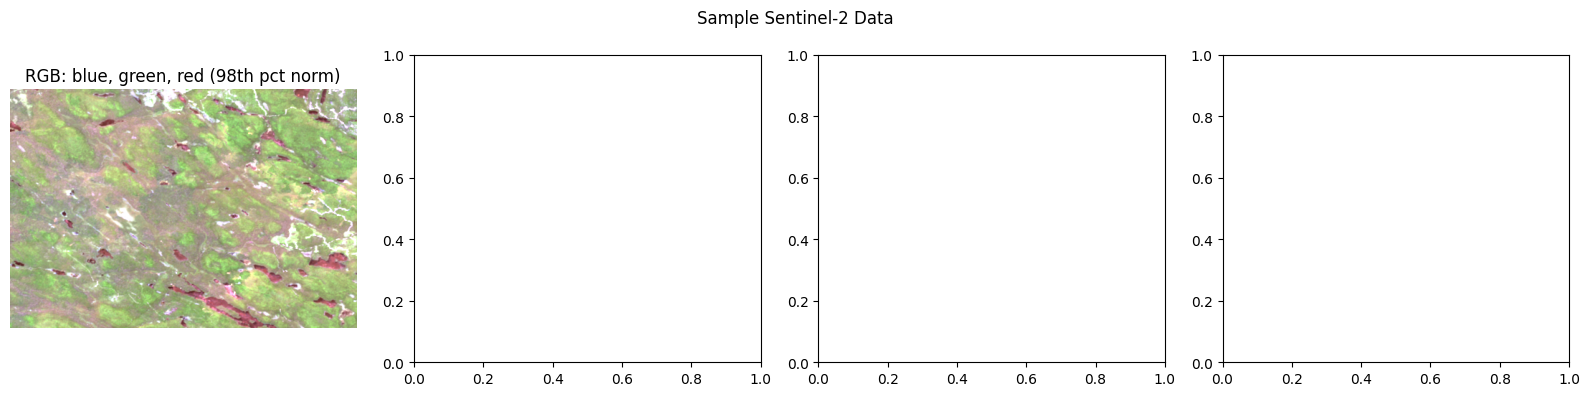

In [53]:
sample = sentinel2_dataset[queries[1]]
print(f"Sample shape: {sample['image'].shape}")
sentinel2_dataset.plot(sample, bands=["blue", "green", "red"], show_titles=True, suptitle="Sample Sentinel-2 Data")

Sample shape: torch.Size([9, 256, 256])


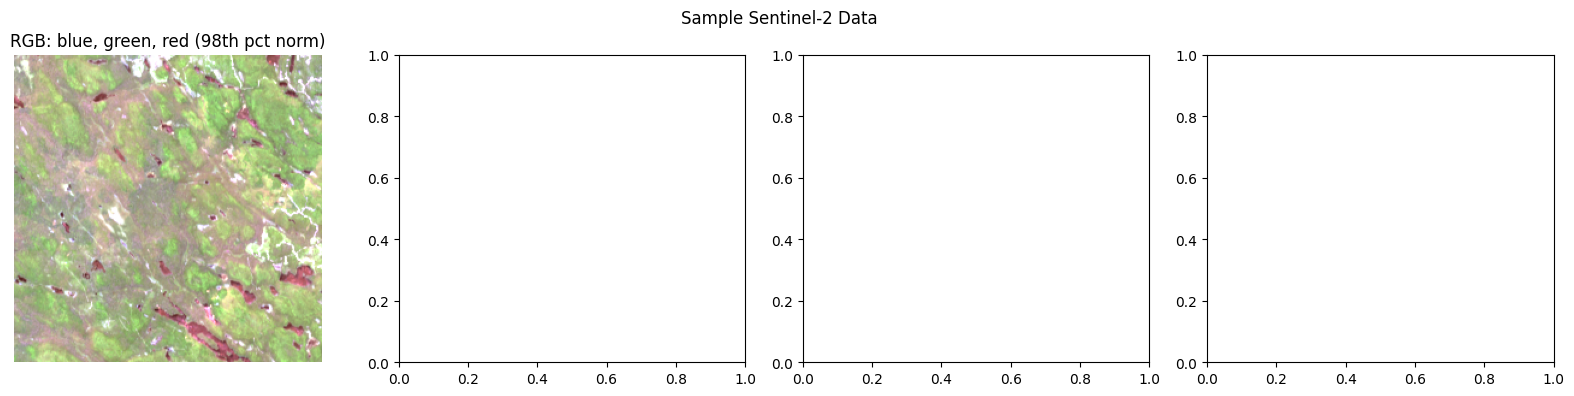

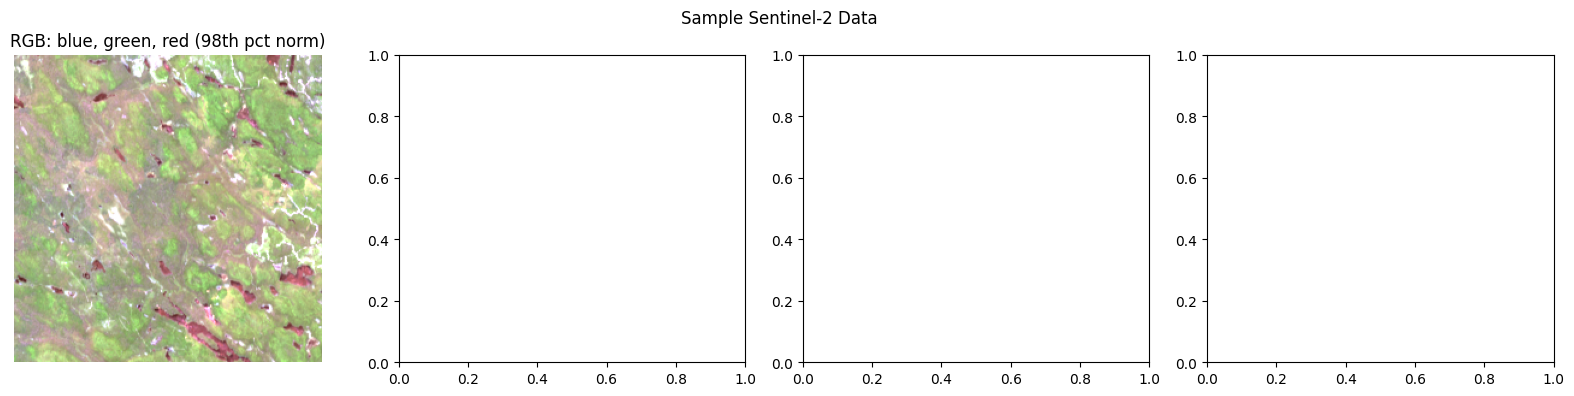

In [51]:
sample = sentinel2_dataset[queries[1]]
print(f"Sample shape: {sample['image'].shape}")
sentinel2_dataset.plot(sample, bands=["blue", "green", "red"], show_titles=True, suptitle="Sample Sentinel-2 Data")

In [75]:
sample = sentinel2_dataset[queries[1]]
sample['image'][0]

tensor([[0.0232, 0.0223, 0.0233,  ..., 0.0207, 0.0207, 0.0197],
        [0.0229, 0.0231, 0.0235,  ..., 0.0220, 0.0208, 0.0195],
        [0.0233, 0.0232, 0.0253,  ..., 0.0220, 0.0209, 0.0206],
        ...,
        [0.0231, 0.0230, 0.0232,  ..., 0.0200, 0.0204, 0.0245],
        [0.0226, 0.0212, 0.0212,  ..., 0.0197, 0.0204, 0.0236],
        [0.0244, 0.0251, 0.0245,  ..., 0.0188, 0.0198, 0.0196]])

### extracting patches to zarr

In [79]:
import os
import numpy as np
import rasterio
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def _compute_min_max(file_path):
    """Read a multi-band raster and compute min/max per band."""
    try:
        with rasterio.open(file_path) as src:
            results = []
            for i in range(1, src.count + 1):  # 1-based index
                data = src.read(i)
                valid_stats = data[~np.isnan(data)]
                min_val = valid_stats.min() if valid_stats.size > 0 else None
                max_val = valid_stats.max() if valid_stats.size > 0 else None
                results.append((min_val, max_val))
            return results
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def compute_tile_min_max(folder_path, num_bands, num_workers=None):
    """
    Computes per-band min/max for all multi-band .tif tiles in a folder.
    Assumes each tile has `num_bands` stacked along axis 0.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    # List all tif files
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")]

    print(f"Processing {len(all_files)} tiles with {num_workers} workers...")

    # Collect results
    band_results = [[] for _ in range(num_bands)]

    with Pool(num_workers) as pool:
        for r in tqdm(pool.imap_unordered(_compute_min_max, all_files), total=len(all_files)):
            if r is not None:
                for band_idx, (bmin, bmax) in enumerate(r):
                    band_results[band_idx].append((bmin, bmax))

    # Aggregate min/max across all tiles
    results = {}
    for band_idx in range(num_bands):
        if band_results[band_idx]:
            mins, maxs = zip(*band_results[band_idx])
            results[f"band_{band_idx+1}"] = {
                "min": np.min(mins),
                "max": np.max(maxs),
            }
        else:
            results[f"band_{band_idx+1}"] = {"min": None, "max": None}

    return results



In [81]:
# Example usage
folder = sentinel2_dataset.paths
ALL_BANDS = sentinel2_dataset.all_bands  # or whatever you pass
band_stats = compute_tile_min_max(folder, len(ALL_BANDS))
print(band_stats)

Processing 118 tiles with 11 workers...


100%|██████████| 118/118 [00:48<00:00,  2.44it/s]

{'band_1': {'min': np.float32(0.0), 'max': np.float32(1.7154)}, 'band_2': {'min': np.float32(0.0), 'max': np.float32(1.6448)}, 'band_3': {'min': np.float32(0.0), 'max': np.float32(1.5832)}, 'band_4': {'min': np.float32(0.0), 'max': np.float32(1.5496)}, 'band_5': {'min': np.float32(0.0), 'max': np.float32(1.5105)}, 'band_6': {'min': np.float32(0.0), 'max': np.float32(1.5329)}, 'band_7': {'min': np.float32(-1.0), 'max': np.float32(1.0)}, 'band_8': {'min': np.float32(-1.0), 'max': np.float32(1.0)}, 'band_9': {'min': np.float32(-469.99973), 'max': np.float32(81.74438)}}


In [84]:
import os
import rasterio
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import traceback

def _normalize_tile(file_path, output_folder, band_stats, clip=True):
    """
    Normalizes a single raster tile (with stacked bands) using provided per-band min/max.
    Saves the normalized tile to output_folder.
    """
    try:
        basename = os.path.basename(file_path)

        with rasterio.open(file_path) as src:
            profile = src.profile
            data = src.read().astype(np.float32)  # shape = (bands, H, W)

            # Normalize each band
            for band_idx in range(data.shape[0]):
                band_key = f'band_{band_idx+1}'
                if band_key not in band_stats:
                    print(f"Skipping {band_key} in {basename}: no stats available")
                    continue

                min_val = band_stats[band_key]['min']
                max_val = band_stats[band_key]['max']

                if min_val is None or max_val is None:
                    print(f"Skipping {band_key} in {basename}: invalid stats")
                    continue

                # Clip + normalize
                band_data = data[band_idx]
                if clip:
                    band_data = np.clip(band_data, min_val, max_val)

                data[band_idx] = (band_data - min_val) / (max_val - min_val + 1e-6)

            # Update profile for float32 output
            profile.update(dtype=rasterio.float32, compress='lzw')

            # Save normalized tile
            out_path = os.path.join(output_folder, basename)
            os.makedirs(output_folder, exist_ok=True)
            with rasterio.open(out_path, 'w', **profile) as dst:
                dst.write(data)

    except Exception as e:
        print(f"Error normalizing {file_path}: {e}")
        # traceback.print_exc()


def normalize_tiles(folder_path, output_folder, band_stats, num_workers=None):
    """
    Normalizes all stacked .tif tiles in a folder using per-band stats.
    Saves normalized tiles to output_folder.
    """
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    # List all tif files
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".tif")]

    print(f"Normalizing {len(all_files)} tiles with {num_workers} workers...")

    args = [(f, output_folder, band_stats) for f in all_files]

    with Pool(num_workers) as pool:
        for _ in tqdm(pool.starmap(_normalize_tile, args), total=len(args)):
            pass


# Example usage
folder = "../data/sentinel2_tiles_ee"
output_folder = "../data/sentinel2_tiles_ee_normalized"

normalize_tiles(folder, output_folder, band_stats, num_workers=8)


Normalizing 118 tiles with 8 workers...


100%|██████████| 118/118 [00:00<00:00, 1846745.79it/s]


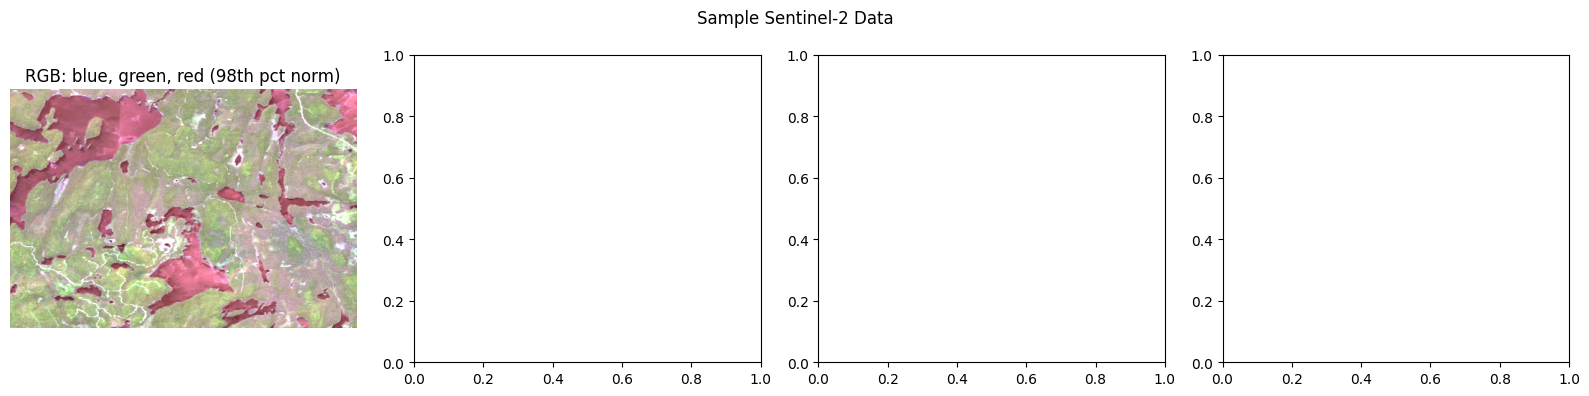

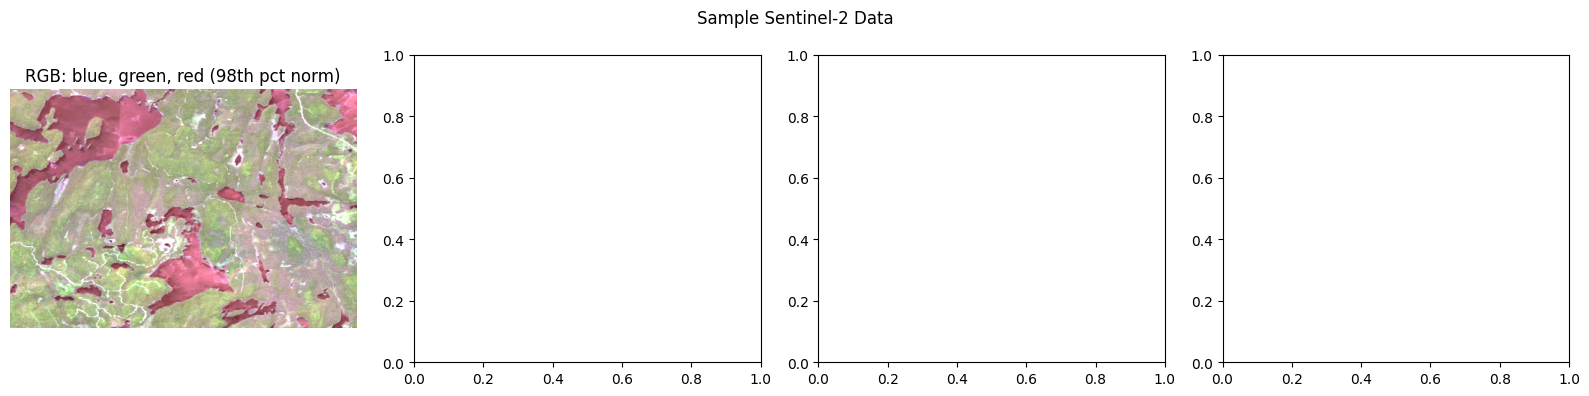

In [85]:
sentinel2_dataset = SimpleRasterDataset(
    paths="../data/sentinel2_tiles_ee_normalized",
    all_bands=["blue", "green", "red", "nir", "swir1", "swir2", "ndvi", "ndwi", "evi"],
    transforms=None,
    crs="EPSG:4326"
)
point_geo_sampler = PointGeoSampler(
    sentinel2_dataset,
    processed_species_original_locations,
    side_length_meters=10000
)

queries = point_geo_sampler.get_all_queries()

sample = sentinel2_dataset[queries[1]]
sentinel2_dataset.plot(sample, bands=["blue", "green", "red"], show_titles=True, suptitle="Sample Sentinel-2 Data")

In [100]:
sentinel2_dataset[queries[0]]['image'].shape

torch.Size([9, 334, 484])

In [ ]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# sentinel2_dataset = SimpleRasterDataset(
#     paths="../data/sentinel2_tiles_ee_normalized",
#     all_bands=["blue"],
#     transforms=None,
#     crs="EPSG:4326"
# )
# point_geo_sampler = PointGeoSampler(
#     sentinel2_dataset,
#     processed_species_original_locations,
#     side_length_meters=10000
# )
# queries = point_geo_sampler.get_all_queries()
# patch_shapes = []
# for idx in tqdm(range(len(queries))):
#     # get first band only
#     patch = sentinel2_dataset[queries[idx]]['image'][0]
#     patch_shapes.append(patch.shape)  # (height, width)

# # Compute min height and width
# heights, widths = zip(*patch_shapes)
# min_height = min(heights)
# min_width = min(widths)
# print(f"Minimum patch size across all locations: ({min_height}, {min_width})")


100%|██████████| 24960/24960 [06:39<00:00, 62.41it/s] 

Minimum patch size across all locations: (333, 471)


In [10]:
# Path to the output Zarr store
zarr_output_path = '../data/zarr_patches/pred100.zarr'
side_length_meters = 10000
locations = processed_species_original_locations.geometry
sentinel2_dataset = SimpleRasterDataset(
    paths="../data/sentinel2_tiles_ee_normalized",
    all_bands=["blue", "green", "red", "nir", "swir1", "swir2", "ndvi", "ndwi", "evi"],
    transforms=None,
    crs="EPSG:4326",
    target_size=256  # Resize patches to 256x256 pixels
)

# Now, call the optimized function with your data
extract_patches_sequentially(
    dataset=sentinel2_dataset,
    locations=locations,
    side_length_meters=side_length_meters,
    zarr_path=zarr_output_path,
    group_name="sentinel2",
    memory_threshold_mb=4096
)

First query: BoundingBox(minx=np.float64(-78.24934627240191), maxx=np.float64(-78.1189517275981), miny=np.float64(46.4105834412505), maxy=np.float64(46.500414558749604), mint=0.0, maxt=9.223372036854776e+18)
Dataset info:
  - separate_files: False
  - n_bands: 9
  - n_files: 118
  - patch_shape: (9, 256, 256)
Pre-allocating Zarr arrays...
Processing combined bands sequentially with async saving...


Processing patches (seq+async):   7%|▋         | 1817/24732 [00:27<06:23, 59.73it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  12%|█▏        | 2914/24732 [00:53<06:08, 59.29it/s]

Saved 1821 patches in 15.55s


Processing patches (seq+async):  15%|█▍        | 3635/24732 [01:04<04:26, 79.26it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  19%|█▉        | 4766/24732 [01:26<07:01, 47.39it/s]

Saved 1821 patches in 10.82s


Processing patches (seq+async):  22%|██▏       | 5459/24732 [01:36<04:09, 77.13it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  26%|██▋       | 6511/24732 [01:57<05:18, 57.28it/s]

Saved 1821 patches in 11.47s


Processing patches (seq+async):  29%|██▉       | 7279/24732 [02:10<05:12, 55.80it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  33%|███▎      | 8265/24732 [02:32<05:05, 53.93it/s]

Saved 1821 patches in 11.17s


Processing patches (seq+async):  37%|███▋      | 9100/24732 [02:44<04:49, 53.91it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  40%|███▉      | 9846/24732 [03:07<07:09, 34.70it/s]  

Saved 1821 patches in 11.10s


Processing patches (seq+async):  44%|████▍     | 10925/24732 [03:27<03:52, 59.44it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  48%|████▊     | 11775/24732 [03:48<04:30, 47.95it/s]

Saved 1821 patches in 10.95s


Processing patches (seq+async):  52%|█████▏    | 12744/24732 [04:08<03:35, 55.67it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  55%|█████▌    | 13614/24732 [04:28<03:19, 55.60it/s]

Saved 1821 patches in 11.19s


Processing patches (seq+async):  59%|█████▉    | 14567/24732 [04:44<02:11, 77.25it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  63%|██████▎   | 15510/24732 [05:05<02:54, 52.86it/s]

Saved 1821 patches in 11.03s


Processing patches (seq+async):  66%|██████▋   | 16388/24732 [05:22<03:06, 44.68it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  69%|██████▉   | 17041/24732 [05:43<02:59, 42.83it/s]

Saved 1821 patches in 10.86s


Processing patches (seq+async):  74%|███████▎  | 18204/24732 [06:07<01:50, 58.91it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  76%|███████▋  | 18912/24732 [06:37<01:46, 54.61it/s]

Saved 1821 patches in 19.47s


Processing patches (seq+async):  81%|████████  | 20024/24732 [06:53<01:07, 70.11it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  85%|████████▌ | 21098/24732 [07:14<01:06, 54.57it/s]

Saved 1821 patches in 11.30s


Processing patches (seq+async):  88%|████████▊ | 21850/24732 [07:25<00:36, 79.36it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async):  93%|█████████▎| 23093/24732 [07:46<00:21, 76.25it/s]

Saved 1821 patches in 11.18s


Processing patches (seq+async):  96%|█████████▌| 23672/24732 [07:54<00:15, 70.24it/s]

Queueing batch (~4097.25 MB) for saving...


Processing patches (seq+async): 100%|██████████| 24732/24732 [08:14<00:00, 50.03it/s]

Saved 1821 patches in 11.80s


Queueing final batch (~2382.75 MB) for saving...
Saved 1059 patches in 5.77s
Extraction complete in 506.25s
Patches saved at ../data/zarr_patches/pred100.zarr


### Extracting the location data


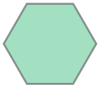

In [54]:
# create an hexagon around a location
import geopandas as gpd
from shapely.geometry import Polygon


def create_hexagon(center, square_meters):
    """
    Create a hexagon polygon around a center point with a specified area in square meters.
    
    Parameters:
    - center (tuple): (x, y) coordinates of the hexagon's center.
    - square_meters (float): Desired area of the hexagon in square meters.
    
    Returns:
    - Polygon: A shapely Polygon object representing the hexagon.
    
    Raises:
    - ValueError: If square_meters is non-positive.
    """
    if square_meters <= 0:
        raise ValueError("Area must be positive.")
    
    # Calculate radius for a regular hexagon with given area
    # Area = (3 * sqrt(3) / 2) * r^2
    radius = np.sqrt((2 * square_meters) / (3 * np.sqrt(3)))
    
    # Generate angles for 6 vertices plus closing point
    angle = np.linspace(0, 2 * np.pi, 7)
    
    # Calculate x, y coordinates of vertices
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    
    # Create and return the Polygon
    return Polygon(zip(x, y))
create_hexagon(processed_species_original_locations.geometry.iloc[0].coords[0], 307.092)#same area as h3 at resolution 12

In [9]:
import os
import numpy as np
import rasterio
import pandas as pd
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def _raster_at_points_worker(args):
    """Worker to extract raster values at a set of points."""
    raster_path, points = args
    values = []
    with rasterio.open(raster_path) as src:
        coords = [(pt.x, pt.y) for pt in points]
        for val in src.sample(coords):
            value = val[0]
            if src.nodata is not None and value == src.nodata:
                values.append(None)
            elif np.isnan(value):
                values.append(None)
            else:
                values.append(float(value))
    return values

def raster_values_at_points_parallel(raster_path, points, n_jobs=None):
    """
    Extract raster values at points using multiprocessing (no chunking).
    Each worker opens the raster and samples the *full point set*.
    
    Parameters
    ----------
    raster_path : str
        Path to the raster file.
    points : list of shapely.geometry.Point
        Points in same CRS as raster.
    n_jobs : int, optional
        Number of processes (default: cpu_count()).
    
    Returns
    -------
    list of float or None
        Raster values at each point.
    """
    if n_jobs is None:
        n_jobs = cpu_count()

    # just one worker in this case would be same speed,
    # but we allow multiple in case you want per-raster parallelism
    args = [(raster_path, points)]
    with Pool(processes=n_jobs) as pool:
        results = list(tqdm(pool.imap(_raster_at_points_worker, args),
                            total=len(args), desc="Sampling points"))
    return results[0]

def raster_values_from_folder(raster_folder, points, n_jobs=None):
    """
    Extract raster values at points for all .tif files in a folder.
    Returns a DataFrame with one column per raster.
    """
    tif_files = [f for f in os.listdir(raster_folder) if f.endswith(".tif")]
    tif_files.sort()

    results = {}
    for fname in tif_files:
        raster_path = os.path.join(raster_folder, fname)
        print(f"Extracting values from {fname} ...")
        vals = raster_values_at_points_parallel(raster_path, points, n_jobs=n_jobs)
        band_name = os.path.splitext(fname)[0]  # drop .tif
        results[band_name] = vals

    return pd.DataFrame(results)

points = processed_species_original_locations.geometry.apply(lambda geom: Point(geom.x, geom.y))
raster_folder = "../data/data_layers/predictors_100_QC_normalized"
raster_values_df = raster_values_from_folder(raster_folder, points, n_jobs=6)

Extracting values from alluvion.tif ...


Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Extracting values from annual_precipitation_amount.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from annual_range_of_air_temperature.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Extracting values from barren.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from bulk_density.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from clay.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Extracting values from combined_mask.tif ...



Sampling points: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Extracting values from coniferous.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Extracting values from cropland.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from deciduous.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from depot.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Extracting values from distance_to_roads.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

Extracting values from eau_peu_profonde.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from elevation.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from eolien.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from geomflat.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Extracting values from geomfootslope.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from glaciaire.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from glaciolacustre.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from human_modification.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from indifferencie.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Extracting values from isothermality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Extracting values from lacustre.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from lai.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Extracting values from marais.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from marecage.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from mean_annual_air_temperature.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Extracting values from mean_daily_maximum_air_temperature_of_the_warmest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_coldest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_driest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_warmest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_mean_air_temperatures_of_the_wettest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Extracting values from mean_daily_minimum_air_temperature_of_the_coldest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Extracting values from mean_diurnal_air_temperature_range.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_coldest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_driest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_warmest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from mean_monthly_precipitation_amount_of_the_wettest_quarter.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Extracting values from mixed.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Extracting values from ndvi.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Extracting values from nitrogen.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from organic_carbon_density.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from organique.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from ph.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Extracting values from polar_grass.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from prairie_humide.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Extracting values from precipitation_amount_of_the_driest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Extracting values from precipitation_amount_of_the_wettest_month.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from precipitation_seasonality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Extracting values from quaternaire.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Extracting values from roche.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from ruggedness.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from sand.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from silt.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

Extracting values from soil_organic_carbon.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from taiga.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from temperate_grass.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from temperate_shrub.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

Extracting values from temperature_seasonality.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Extracting values from till.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

Extracting values from tourbiere_boisee.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Extracting values from tourbiere_indifferenciee.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

Extracting values from tourbiere_minerotrophe.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Extracting values from tourbiere_ombrotrophe.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from urban.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

Extracting values from water.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

Extracting values from wetland.tif ...



Sampling points: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


In [12]:
processed_species_original_locations_point_data = processed_species_original_locations.copy()
processed_species_original_locations_point_data = processed_species_original_locations_point_data.reset_index(drop=True)
processed_species_original_locations_point_data = pd.concat([processed_species_original_locations_point_data, raster_values_df], axis=1)
processed_species_original_locations_point_data.drop(columns=['species_count', 'id', 'expanded_cells'], inplace=True)  # remove geometry column
processed_species_original_locations_point_data.to_csv("../data/saved_df/processed_species_original_locations_point_data.csv", index=False)

In [13]:
processed_species_original_locations_point_data

geometry  \
0      POINT (-741157.228 322206.012)   
1      POINT (-740968.538 322143.985)   
2      POINT (-740825.054 322103.996)   
3      POINT (-740548.834 322019.529)   
4      POINT (-740734.244 322076.046)   
...                               ...   
24727   POINT (-169654.451 158261.31)   
24728  POINT (-169931.484 157866.788)   
24729  POINT (-169822.528 158022.118)   
24730  POINT (-169737.425 158143.181)   
24731  POINT (-169362.071 158677.379)   

                                            species_list  alluvion  \
0      ['ARN', 'AUR', 'BOP', 'CHH', 'COG', 'CON', 'DR...       0.0   
1      ['APA', 'ARN', 'ASM', 'AUR', 'BAT', 'BOP', 'CH...       0.0   
2      ['ARN', 'ASM', 'AUR', 'BOP', 'CAX', 'CLB', 'CO...       0.0   
3      ['ARN', 'ASM', 'BOP', 'CHH', 'CLB', 'COC', 'CO...       0.0   
4      ['ARN', 'ASM', 'BOP', 'CLB', 'COC', 'DIE', 'DR...       0.0   
...                                                  ...       ...   
24727  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...       0.0   
24728  ['ACP', 'ARN', 'ASA', 'BOJ', 'BOP', 'CAX', 'CI...       0.0   
24729  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...       0.0   
24730  ['ACP', 'ACR', 'ARN', 'ASA', 'BOJ', 'BOP', 'CA...       0.0   
24731  ['AME', 'ASA', 'ATF', 'BAT', 'BOJ', 'BOP', 'CA...       0.0   

       annual_precipitation_amount  annual_range_of_air_temperature  barren  \
0                         0.437328                         0.863043     0.0   
1                         0.438532                         0.863043     0.0   
2                         0.438532                         0.863043     0.0   
3                         0.438686                         0.863043     0.0   
4                         0.438532                         0.863043     0.0   
...                            ...                              ...     ...   
24727                     0.541337                         0.821739     0.0   
24728                     0.523494                         0.824965     0.0   
24729                     0.541337                         0.821739     0.0   
24730                     0.541337                         0.821739     0.0   
24731                     0.546886                         0.826087     0.0   

       bulk_density      clay  combined_mask  coniferous  ...  \
0          0.800000  0.404715            1.0    0.880000  ...   
1          0.800000  0.404715            1.0    0.797815  ...   
2          0.800000  0.404715            1.0    0.780000  ...   
3          0.800000  0.404715            1.0    0.259833  ...   
4          0.800000  0.404715            1.0    0.459946  ...   
...             ...       ...            ...         ...  ...   
24727      0.703704  0.198428            1.0    0.040000  ...   
24728      0.682436  0.187147            1.0    0.000000  ...   
24729      0.703704  0.198428            1.0    0.000000  ...   
24730      0.703704  0.198428            1.0    0.000000  ...   
24731      0.703704  0.198428            1.0    0.040487  ...   

       temperate_shrub  temperature_seasonality      till  tourbiere_boisee  \
0                  0.0                 0.827959  0.990069               0.0   
1                  0.0                 0.827025  0.726613               0.0   
2                  0.0                 0.827025  0.918152               0.0   
3                  0.0                 0.826880  0.000000               0.0   
4                  0.0                 0.827025  0.135556               0.0   
...                ...                      ...       ...               ...   
24727              0.0                 0.774299  1.000000               0.0   
24728              0.0                 0.777015  1.000000               0.0   
24729              0.0                 0.774299  1.000000               0.0   
24730              0.0                 0.774299  1.000000               0.0   
24731              0.0                 0.777804  0.923688               0.0   

       tourbiere

In [17]:
def create_target_species_df(species_name, df):
    df_present = df[['species_list', 'geometry']].copy()
    # Use single brackets to get the Series and apply to each list directly
    df_present[species_name] = df_present['species_list'].apply(lambda x: 1 if species_name in x else 0)
    return df_present[species_name]

In [18]:
target_df = create_target_species_df("ERP", processed_species_original_locations_point_data)

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def feature_importance_from_stats(stats_list, target_df, threshold=0.01):
    """
    Train RandomForest on zonal stats to predict binary target,
    return feature importances and model performance.
    
    Parameters
    ----------
    stats_list : list of dict
        Output from zonal_stats_simple
    target_df : pd.DataFrame
        Must contain a column 'target' with 0/1 values,
        same length/order as stats_list
    
    Returns
    -------
    feature_importances : pd.Series
    model : trained RandomForestClassifier
    """
    # Convert stats list to DataFrame
    X = pd.DataFrame(stats_list)
    
    # Align with target
    X["target"] = target_df.values
    y = X.pop("target")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Model
    model = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
    model.fit(X_train, y_train)
    
    # Feature importances
    feature_importances = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=False)

    # Apply threshold
    feature_importances = feature_importances[feature_importances > threshold]
    return feature_importances


In [30]:
feature_importance = feature_importance_from_stats(
    processed_species_original_locations_point_data.drop(columns=['species_list', 'geometry']),
    target_df=target_df,
    threshold=0.01
)

### Exploring the zarr dataset


In [22]:
processed_species_original_locations.to_crs(epsg=4326)

geometry species_count  \
0       POINT (-78.18415 46.4555)            23   
1       POINT (-78.1816 46.45517)            30   
2      POINT (-78.17968 46.45499)            29   
3      POINT (-78.17597 46.45457)            24   
4      POINT (-78.17846 46.45485)            25   
...                           ...           ...   
24727  POINT (-70.66489 45.40489)            41   
24728  POINT (-70.66828 45.40126)            38   
24729  POINT (-70.66694 45.40269)            38   
24730  POINT (-70.66591 45.40381)            44   
24731  POINT (-70.66132 45.40872)            48   

                                            species_list  \
0      ['ARN', 'AUR', 'BOP', 'CHH', 'COG', 'CON', 'DR...   
1      ['APA', 'ARN', 'ASM', 'AUR', 'BAT', 'BOP', 'CH...   
2      ['ARN', 'ASM', 'AUR', 'BOP', 'CAX', 'CLB', 'CO...   
3      ['ARN', 'ASM', 'BOP', 'CHH', 'CLB', 'COC', 'CO...   
4      ['ARN', 'ASM', 'BOP', 'CLB', 'COC', 'DIE', 'DR...   
...                                                  ...   
24727  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...   
24728  ['ACP', 'ARN', 'ASA', 'BOJ', 'BOP', 'CAX', 'CI...   
24729  ['AME', 'ARN', 'ASA', 'BAT', 'BOJ', 'BOP', 'CA...   
24730  ['ACP', 'ACR', 'ARN', 'ASA', 'BOJ', 'BOP', 'CA...   
24731  ['AME', 'ASA', 'ATF', 'BAT', 'BOJ', 'BOP', 'CA...   

                                  id  \
0      -78.184149_46.455499000000025   
1       -78.181605_46.45517300000003   
2       -78.179683_46.45498900000005   
3        -78.17597_46.45456800000002   
4      -78.178462_46.454849000000024   
...                              ...   
24727           -70.664893_45.404891   
24728  -70.668275_45.401263999999976   
24729   -70.666945_45.40269200000003   
24730   -70.665906_45.40380500000003   
24731   -70.661323_45.40871599999998   

                                          expanded_cells  
0      POLYGON ((-735389.9604645551 326294.2540275563...  
1      POLYGON ((-735201.2868360623 326232.23798954, ...  
2      POLYGON ((-735057.8160013517 326192.2575757417...  
3      POLYGON ((-734781.6213852125 326107.8056918821...  
4      POLYGON ((-734967.0147434833 326164.3128827983...  
...                                                  ...  
24727  POLYGON ((-163963.3253316314 162369.5234943101...  
24728  POLYGON ((-164240.3119819813 161975.0094317245...  
24729  POLYGON ((-164131.37471615247 162130.336705536...  
24730  POLYGON ((-164046.28510913998 162251.396796683...  
24731  POLYGON ((-163670.9937771002 162785.5843678941...  

[24732 rows x 5 columns]

In [16]:
import zarr
import numpy as np

# Path to your Zarr file (update with your file path)
zarr_path = "../data/zarr_patches/pred100.zarr"

# Open the Zarr file
store = zarr.open(zarr_path, mode="r")
main_group = store['raster_data']

In [31]:
# To access the first array in the pred100_group, use array_keys() and then index
first_patch_id = list(pred100_group.array_keys())[0]

In [32]:
first_patch_id

'-331648_6281_136309_3800'

In [129]:
import zarr
from torch.utils.data import Dataset

class CustomZarrDataset(Dataset):
    def __init__(self, zarr_groups_name, targets, zarr_path, transform=None, target_transform=None,
                 features_index=None, indices=None):
        """
        Parameters
        ----------
        zarr_groups_name : list of str
            Names of groups inside "raster_data".
        zarr_path : str
            Path to the Zarr store.
        transform : callable, optional
            Transformation applied to inputs.
        target_transform : callable, optional
            Transformation applied to targets.
        features_index : list or array-like, optional
            Subset of features to extract (only applied if group_name == "pred_100").
        indices : list of str or list of int, optional
            - If list of str: use these patch_ids directly.
            - If list of int: subset patch_ids by position.
        """
        self.zarr_groups_name = zarr_groups_name
        self.zarr_path = zarr_path
        self.transform = transform
        self.target_transform = target_transform
        self.store = zarr.open(zarr_path, mode="r")
        self.main_group = self.store["raster_data"]
        self.targets = targets
        all_patch_ids = list(self.main_group[self.zarr_groups_name[0]].array_keys())

        # If indices are provided, filter patch_ids
        if indices is None:
            self.patch_ids = all_patch_ids
        elif isinstance(indices[0], str):  # user passed patch_id strings
            self.patch_ids = [pid for pid in all_patch_ids if pid in indices]
        else:  # assume integer indices
            self.patch_ids = [all_patch_ids[i] for i in indices]

        self.features_index = features_index
        self.input_shapes = []
        for group_name in self.zarr_groups_name:
            shape = self.main_group[group_name][self.patch_ids[0]].shape
            if group_name == "pred_100" and self.features_index is not None:
            # Use (len(features_index), h, w) instead of all bands
                h, w = shape[1], shape[2]
                self.input_shapes.append((len(self.features_index), h, w))
            else:
                self.input_shapes.append(shape)
        

    def __len__(self):
        return len(self.patch_ids)

    def __getitem__(self, idx):
        items = []
        patch_id = self.patch_ids[idx]
        for group_name in self.zarr_groups_name:
            group = self.main_group[group_name]
            if self.features_index is not None and group_name == "pred_100":
                patch_data = group[patch_id][self.features_index]
            else:
                patch_data = group[patch_id][:]
            if self.transform:
                patch_data = self.transform(patch_data)
            patch_data = torch.tensor(patch_data, dtype=torch.float32)
            items.append(patch_data)
        items.append(self.targets[idx])
        return items
    

import zarr
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomZarrDatasetV2(Dataset):
    def __init__(self, zarr_groups_name, targets, zarr_path,
                 transform=None, target_transform=None,
                 features_index=None, indices=None):
        self.zarr_groups_name = zarr_groups_name
        self.zarr_path = zarr_path
        self.transform = transform
        self.target_transform = target_transform
        self.store = zarr.open(zarr_path, mode="r")
        if features_index is not None:
            self.features_index = np.array(features_index, dtype=int)
        else:
            self.features_index = None

        # Open arrays for each group, cache references for fast access
        self.groups = {g: self.store[g] for g in self.zarr_groups_name}

        # Number of samples in Zarr
        zarr_length = self.groups[self.zarr_groups_name[0]].shape[0]
        target_length = len(targets)
        max_len = min(zarr_length, target_length)

        # Validate and apply indices
        if indices is None:
            self.indices = np.arange(max_len, dtype=int)
        else:
            indices = np.array(indices, dtype=int)
            self.indices = indices[indices < max_len]

        # Pre-slice targets to only the chosen subset
        self.targets = np.asarray(targets)[self.indices]

        # Compute input shapes (without batch dim)
        self.input_shapes = []
        for g in self.zarr_groups_name:
            shape = self.groups[g].shape  # (N, C, H, W)
            if g == "pred_100" and self.features_index is not None:
                _, _, h, w = shape
                self.input_shapes.append((len(self.features_index), h, w))
            else:
                self.input_shapes.append(shape[1:])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        items = []

        for g in self.zarr_groups_name:
            arr = self.groups[g]
            # Use direct slicing for fast access
            if g == "pred_100" and self.features_index is not None:
                # Fast slicing: arr[real_idx, features_index, :, :]
                patch_data = arr.get_orthogonal_selection((real_idx, self.features_index, slice(None), slice(None)))
            else:
                patch_data = arr[real_idx]
            if self.transform:
                patch_data = self.transform(patch_data)
            # Avoid unnecessary copy if already float32
            patch_data = torch.from_numpy(np.asarray(patch_data, dtype=np.float32))
            items.append(patch_data)

        target = self.targets[idx]
        if self.target_transform:
            target = self.target_transform(target)
        target = torch.as_tensor(target, dtype=torch.float32)

        items.append(target)
        return items



In [100]:
import zarr
import numpy as np
from tqdm import tqdm

# Open old store
old = zarr.open("../data/zarr_patches/pred100.zarr", mode="r")
old_store = old["raster_data"]
# List patch ids
patch_ids = list(old_store["sentinel2"].array_keys())
N = len(patch_ids)

# Get shapes
c1, h1, w1 = old_store["sentinel2"][patch_ids[0]].shape
c2, h2, w2 = old_store["pred_100"][patch_ids[0]].shape

# Create new store
new = zarr.open("new_store.zarr", mode="w")

# Choose chunking: one sample per chunk is usually best for DL
sentinel2_arr = new.create_array(
    "sentinel2",
    shape=(N, c1, h1, w1),
    chunks=(1, c1, h1, w1),
    dtype="float32"
)
pred100_arr = new.create_array(
    "pred_100",
    shape=(N, c2, h2, w2),
    chunks=(1, c2, h2, w2),
    dtype="float32"
)

# Fill them
for i, pid in enumerate(tqdm(patch_ids)):
    sentinel2_arr[i] = old_store["sentinel2"][pid][:]
    pred100_arr[i] = old_store["pred_100"][pid][:]


100%|██████████| 24732/24732 [16:26<00:00, 25.08it/s]


In [37]:
def get_pred_100_band_names():
    folder = "../data/data_layers/predictors_100_QC_normalized"
    band_names = [f.split('.')[0] for f in os.listdir(folder) if f.endswith('.tif')]
    band_names.sort()  # Ensure consistent order
    return band_names

In [46]:
processed_species_original_locations_point_data = pd.read_csv("../data/saved_df/processed_species_original_locations_point_data.csv")
target_df = create_target_species_df("ERP", processed_species_original_locations_point_data)
feature_importance = feature_importance_from_stats(
    processed_species_original_locations_point_data.drop(columns=['species_list', 'geometry']),
    target_df=target_df,
    threshold=0.01
)

feature_importances_indices = feature_importance.index.tolist()
pred_100_band_names = get_pred_100_band_names()
pred_100_indices = [pred_100_band_names.index(band) for band in feature_importances_indices if band in pred_100_band_names]

Total patches in dataset: 2
first patch shape: (3, 100, 100), (9, 256, 256)


In [120]:
zarr_dataset = CustomZarrDatasetV2(
    zarr_groups_name=["pred_100", "sentinel2"],
    zarr_path="new_store.zarr",
    features_index=pred_100_indices,
    targets=target_df.values,
)

### Testing fusion cnn model

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----- Multi-input CNN -----
class SimpleMultiInputCNN(nn.Module):
    def __init__(self, input_shapes):
        """
        input_shapes: list of tuples, e.g. [(67,100,100), (9,256,256)]
        """
        super().__init__()
        self.branches = nn.ModuleList()
        self.flatten_sizes = []

        for c, h, w in input_shapes:
            layers = nn.Sequential(
                nn.Conv2d(c, 16, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Flatten()
            )
            self.branches.append(layers)

            # Compute flatten size dynamically
            with torch.no_grad():
                dummy = torch.zeros(1, c, h, w)
                flat_size = layers(dummy).shape[1]
                self.flatten_sizes.append(flat_size)

        total_flatten = sum(self.flatten_sizes)
        self.fc = nn.Sequential(
            nn.Linear(total_flatten, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # Output logits for BCEWithLogitsLoss
        )

    def forward(self, inputs):
        # inputs: list of tensors, one per branch
        features = [branch(x) for branch, x in zip(self.branches, inputs)]
        merged = torch.cat(features, dim=1)
        out = self.fc(merged)
        return out  # raw logits

In [90]:
model = MultiInputCNN(
    input_shapes=zarr_dataset.input_shapes,
)

In [110]:
target_df

0        0
1        0
2        0
3        0
4        1
        ..
24727    1
24728    1
24729    1
24730    1
24731    1
Name: ERP, Length: 24732, dtype: int64

In [ ]:
target_df = create_target_species_df("ERP", processed_species_original_locations_point_data)
train, val = train_test_split(
    processed_species_original_locations_point_data,
    test_size=0.2,
    random_state=42,
    stratify=target_df
)
train_indices = train.index.tolist()
val_indices = val.index.tolist()


19785
4947


In [130]:
training_targets = target_df.iloc[train_indices].values
validation_targets = target_df.iloc[val_indices].values
training_dataset = CustomZarrDatasetV2(
    zarr_groups_name=["pred_100"],
    zarr_path="new_store.zarr",
    features_index=pred_100_indices,
    indices=train_indices,
    targets=training_targets
)

validation_dataset = CustomZarrDatasetV2(
    zarr_groups_name=["pred_100"],
    zarr_path="new_store.zarr",
    features_index=pred_100_indices,
    indices=val_indices,
    targets=validation_targets
)


In [107]:
training_dataset.input_shapes

[(29, 100, 100)]

In [118]:
print(len(training_dataset))
print(len(validation_dataset))
print(len(train_indices))
print(len(val_indices))

19785
4947
19785
4947


4947


In [131]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# CONFIG
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
epochs = 10
learning_rate = 1e-3

# -----------------------------
# DATALOADERS
# -----------------------------
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# MODEL
# -----------------------------
model = SimpleMultiInputCNN(input_shapes=training_dataset.input_shapes)
model = model.to(device)

# -----------------------------
# LOSS & OPTIMIZER
# -----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# TRAINING LOOP
# -----------------------------
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []
    f1_scores = []
    precision_scores = []
    losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for batch in pbar:
        inputs = [x.to(device).float() for x in batch[:-1]]
        targets = batch[-1].to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * targets.size(0)

        preds = torch.sigmoid(outputs).detach().cpu()
        all_train_preds.extend(preds.numpy())
        all_train_targets.extend(targets.cpu().numpy())

        # Compute batch metrics
        batch_preds_binary = [1 if p > 0.5 else 0 for p in preds.numpy()]
        batch_acc = accuracy_score(targets.cpu().numpy(), batch_preds_binary)
        batch_f1 = f1_score(targets.cpu().numpy(), batch_preds_binary, zero_division=0)
        f1_scores.append(batch_f1)
        precision_scores.append(precision_score(targets.cpu().numpy(), batch_preds_binary, zero_division=0))
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{batch_acc:.4f}",
            "F1": f"{batch_f1:.4f}"
        })
        
    # Epoch-level metrics (optional)
    train_loss /= len(train_loader.dataset)
    train_preds_binary = [1 if p > 0.5 else 0 for p in all_train_preds]
    train_acc = accuracy_score(all_train_targets, train_preds_binary)
    train_f1 = f1_score(all_train_targets, train_preds_binary, zero_division=0)

    print(f"Epoch {epoch+1} summary => Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")


KeyboardInterrupt: 